# Testing of Hypothesis A

This is the hypothesis that the filter works due to concatenation-like latent space, and that the GNN works due to this and message passing.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
import inspect
import logging
import copy

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.decomposition import PCA
from sklearn.metrics import auc, f1_score
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D
from itertools import permutations
from itertools import chain

from torch.nn import Linear
from torch_scatter import scatter, segment_csr, scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric
import yaml

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from torch.utils.checkpoint import checkpoint

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from lightning_modules.GravNet.utils import evaluate_set_metrics, get_metrics, model_evaluation, build_edges, graph_intersection
from lightning_modules.Filter.utils import edge_model_evaluation
%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
logging.basicConfig(level=logging.INFO)

In [63]:
logging.basicConfig(level=logging.WARNING)

## Train 1GeV Embedding

In [45]:
from lightning_modules.Embedding.utils import embedding_model_evaluation

In [46]:
from lightning_modules.Embedding.Models.layerless_embedding import LayerlessEmbedding

with open("../lightning_modules/Embedding/train_coda_small_embedding.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)
        
model = LayerlessEmbedding(hparams)
wandb_logger = WandbLogger(project='End2End-Embedding')
wandb_logger.watch(model)
trainer = Trainer(gpus=1, max_epochs=20, logger=wandb_logger)

train_loss,0.2546
epoch,9
_step,999
_runtime,828
_timestamp,1611855033
val_loss,0.32438
eff,0.51552
pur,0.57132
current_lr,0.002


train_loss,██▅▄▂▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃█
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃█
val_loss,█▅▂▁▂▂▂▁▁▁
eff,▁▅██▇▇████
pur,▁▄▇█▇█████
current_lr,▁▃▄▆██████


wandb: wandb version 0.10.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### Training

In [47]:
trainer.fit(model)

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021000
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021001
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021002
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021004
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021006
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021007
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021008
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021080
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021081
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021082
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021083
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021084
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021085
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021086
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021087
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021088
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021160
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021161
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021162
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021163
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021164
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021165
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021166
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021167
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021168
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021240
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021241
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021242
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021243
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021244
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021245
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021246
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021247
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021248
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021320
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021321
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021322
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021323
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021324
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021325
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021326
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021327
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021328
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021450
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021451
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021452
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021453
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021454
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021455
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021456
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021457
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021458
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021530
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021531
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021532
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021533
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021534
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021535
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021536
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021537
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021538
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Efficiency: 0.2898462414741516
INFO:root:Purity: 0.01583046466112137
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021489']
INFO:root:Efficiency: 0.29810044169425964
INFO:root:Purity: 0.016260113567113876
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003']


INFO:root:Efficiency: 0.5268910527229309
INFO:root:Purity: 0.2811289131641388
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021489']
INFO:root:Efficiency: 0.532550573348999
INFO:root:Purity: 0.31566107273101807
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003']
INFO:root:Efficiency: 0.5290881991386414
INFO:root:Purity: 0.28805041313171387
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021121']
INFO:root:Efficiency: 0.5613496899604797
INFO:root:Purity: 0.28232720494270325
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021102']
INFO:root:Efficiency: 0.5410815477371216
INFO:root:Purity: 0.3020733892917633
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021116']
INFO:root:Efficiency: 0.5291109681129456
INFO:root:Purity: 0.2378460019826889
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab

INFO:root:Efficiency: 0.5891122817993164
INFO:root:Purity: 0.4403384029865265
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021489']
INFO:root:Efficiency: 0.60099196434021
INFO:root:Purity: 0.4746614098548889
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003']
INFO:root:Efficiency: 0.5945885181427002
INFO:root:Purity: 0.4505271911621094
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021121']
INFO:root:Efficiency: 0.6361126899719238
INFO:root:Purity: 0.4431256353855133
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021102']
INFO:root:Efficiency: 0.6098893284797668
INFO:root:Purity: 0.4565170407295227
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021116']
INFO:root:Efficiency: 0.5972015261650085
INFO:root:Purity: 0.4003767669200897
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/tra

INFO:root:Efficiency: 0.5868581533432007
INFO:root:Purity: 0.4533623456954956
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021489']
INFO:root:Efficiency: 0.5983433723449707
INFO:root:Purity: 0.4867364466190338
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003']
INFO:root:Efficiency: 0.5938811302185059
INFO:root:Purity: 0.4657580852508545
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021121']
INFO:root:Efficiency: 0.6342442631721497
INFO:root:Purity: 0.45685818791389465
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021102']
INFO:root:Efficiency: 0.6084018349647522
INFO:root:Purity: 0.473056823015213
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021116']
INFO:root:Efficiency: 0.5959728956222534
INFO:root:Purity: 0.4109005630016327
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/t

INFO:root:Efficiency: 0.5746622681617737
INFO:root:Purity: 0.4712543785572052
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021489']
INFO:root:Efficiency: 0.5851173400878906
INFO:root:Purity: 0.5055387020111084
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003']
INFO:root:Efficiency: 0.5815800428390503
INFO:root:Purity: 0.48240962624549866
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021121']
INFO:root:Efficiency: 0.6196876764297485
INFO:root:Purity: 0.47788217663764954
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021102']
INFO:root:Efficiency: 0.596701979637146
INFO:root:Purity: 0.49070724844932556
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021116']
INFO:root:Efficiency: 0.5810931921005249
INFO:root:Purity: 0.4238243103027344
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab

INFO:root:Efficiency: 0.580609917640686
INFO:root:Purity: 0.48289698362350464
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021489']
INFO:root:Efficiency: 0.58906489610672
INFO:root:Purity: 0.5172117352485657
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003']
INFO:root:Efficiency: 0.5850422978401184
INFO:root:Purity: 0.49777647852897644
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021121']
INFO:root:Efficiency: 0.6280047297477722
INFO:root:Purity: 0.4904075264930725
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021102']
INFO:root:Efficiency: 0.5998528599739075
INFO:root:Purity: 0.5041741132736206
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021116']
INFO:root:Efficiency: 0.5866219401359558
INFO:root:Purity: 0.43904370069503784
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/t

INFO:root:Efficiency: 0.5726059079170227
INFO:root:Purity: 0.48754173517227173
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021489']
INFO:root:Efficiency: 0.5832954049110413
INFO:root:Purity: 0.5244668126106262
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003']
INFO:root:Efficiency: 0.5831197500228882
INFO:root:Purity: 0.5073646306991577
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021121']
INFO:root:Efficiency: 0.6296221613883972
INFO:root:Purity: 0.49581119418144226
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021102']
INFO:root:Efficiency: 0.5969898700714111
INFO:root:Purity: 0.5176407098770142
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021116']
INFO:root:Efficiency: 0.5836755633354187
INFO:root:Purity: 0.44877108931541443
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codala

INFO:root:Efficiency: 0.5767107605934143
INFO:root:Purity: 0.4928622543811798
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021489']
INFO:root:Efficiency: 0.5898746848106384
INFO:root:Purity: 0.5258994102478027
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003']
INFO:root:Efficiency: 0.5893535017967224
INFO:root:Purity: 0.5068498849868774
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021121']
INFO:root:Efficiency: 0.6317763328552246
INFO:root:Purity: 0.4960804879665375
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021102']
INFO:root:Efficiency: 0.6013723015785217
INFO:root:Purity: 0.5150830149650574
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021116']
INFO:root:Efficiency: 0.5891872048377991
INFO:root:Purity: 0.44819873571395874
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/

INFO:root:Efficiency: 0.5684219598770142
INFO:root:Purity: 0.5039690136909485
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021489']
INFO:root:Efficiency: 0.5800057649612427
INFO:root:Purity: 0.5362395644187927
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003']
INFO:root:Efficiency: 0.5771439671516418
INFO:root:Purity: 0.5226799845695496
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021121']
INFO:root:Efficiency: 0.6214724183082581
INFO:root:Purity: 0.509994626045227
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021102']
INFO:root:Efficiency: 0.5925674438476562
INFO:root:Purity: 0.5242613554000854
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021116']
INFO:root:Efficiency: 0.5773846507072449
INFO:root:Purity: 0.46069708466529846
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/t

    if not wait([self.sentinel], timeout):
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


1

### Testing

In [48]:
embedding_model_evaluation(model, trainer, "eff", 0.90)

Exception: The wandb backend process has shutdown

In [74]:
mean_f1s, mean_efficiencies, mean_purities = [], [], []

for r_test in np.arange(1.0, 1.1, 0.1):
    
    mean_efficiency, mean_purity, mean_f1 = evaluate_set_metrics(r_test, model, trainer)
    mean_efficiencies.append(mean_efficiency), mean_purities.append(mean_purity), mean_f1s.append(mean_f1)
    
    print("Mean efficiency: {:.2f}%".format(mean_efficiency*100))
    print("Mean purity: {:.2f}%".format(mean_purity*100))
    print("Mean F1: {:.2f}%".format(mean_f1*100))

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.4169, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   273,   284, ..., 11245, 11628, 11807]]),
 'truth': array([False,  True, False, ..., False, False,  True]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.4221, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,  1966,  3669, ...,  9973, 10048, 10209]]),
 'truth': array([False,  True, False, ..., False,  True, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.3422392651557339 0.9139188275046294
Mean efficiency: 91.39%
Mean purity: 34.22%
Mean F1: 50.95%


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.3569, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   273,   284, ..., 11628, 11807, 11989]]),
 'truth': array([False,  True, False, ..., False,  True, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.3600, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,  1966,  3669, ..., 10222, 10223, 10235]]),
 'truth': array([False,  True, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

0.29214248736765147 0.9385322925332436
Mean efficiency: 93.85%
Mean purity: 29.21%
Mean F1: 45.17%


## Build 1GeV Embedding-Processed Dataset

In [21]:
def construct_downstream(batch, pl_module, datatype):

    # Free up batch.weights for subset of embedding selection
    batch.true_weights = batch.weights

    if 'ci' in pl_module.hparams["regime"]:
        spatial = pl_module(torch.cat([batch.cell_data, batch.x], axis=-1))
    else:
        spatial = pl_module(batch.x)

    # Make truth bidirectional
    e_bidir = torch.cat([batch.layerless_true_edges,
                   torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T], axis=-1)

    # Build the radius graph with radius < r_test
    e_spatial = build_edges(spatial, model.hparams["r_test"], 300) #This step should remove reliance on r_val, and instead compute an r_build based on the EXACT r required to reach target eff/pur

    # Arbitrary ordering to remove half of the duplicate edges
    R_dist = torch.sqrt(batch.x[:,0]**2 + batch.x[:,2]**2)
    e_spatial = e_spatial[:, (R_dist[e_spatial[0]] <= R_dist[e_spatial[1]])]

    if 'weighting' in pl_module.hparams["regime"]:
        weights_bidir = torch.cat([batch.weights, batch.weights])
        e_spatial, y_cluster, new_weights = graph_intersection(e_spatial, e_bidir, using_weights=True, weights_bidir=weights_bidir)
        batch.weights = new_weights
    else:
        e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)

    # Re-introduce random direction, to avoid training bias
    random_flip = torch.randint(2, (e_spatial.shape[1],)).bool()
    e_spatial[0, random_flip], e_spatial[1, random_flip] = e_spatial[1, random_flip], e_spatial[0, random_flip]

    batch.edge_index = e_spatial
    batch.y = y_cluster

    save_downstream(batch, pl_module, datatype)

def save_downstream(batch, pl_module, datatype):

    with open(os.path.join(model.hparams["output_dir"], datatype, batch.event_file[-4:]), 'wb') as pickle_file:
        torch.save(batch, pickle_file)

    logging.info("Saved event {}".format(batch.event_file[-4:]))

In [22]:
model.hparams["r_test"] = 1.49

In [23]:
datatypes = ["train", "val", "test"]
os.makedirs(model.hparams["output_dir"], exist_ok=True)
[os.makedirs(os.path.join(model.hparams["output_dir"], datatype), exist_ok=True) for datatype in datatypes]

[None, None, None]

In [24]:
# By default, the set of examples propagated through the pipeline will be train+val+test set
datasets = {"train": model.trainset, "val": model.valset, "test": model.testset}
total_length = sum([len(dataset) for dataset in datasets.values()])
batch_incr = 0
model.eval()
with torch.no_grad():
    for set_idx, (datatype, dataset) in enumerate(datasets.items()):
        for batch_idx, batch in enumerate(dataset):
            percent = (batch_incr / total_length) * 100
            sys.stdout.flush()
            sys.stdout.write(f'{percent:.01f}% inference complete \r')
            if (not os.path.exists(os.path.join(model.hparams["output_dir"], datatype, batch.event_file[-4:]))):
                batch_to_save = copy.deepcopy(batch)
                batch_to_save = batch_to_save.to(model.device) #Is this step necessary??
                construct_downstream(batch_to_save, model, datatype)                      

            batch_incr += 1

INFO:root:Saved event 1085


INFO:root:Saved event 1516


INFO:root:Saved event 1050
INFO:root:Saved event 1266


INFO:root:Saved event 1291


INFO:root:Saved event 1018


INFO:root:Saved event 1505
INFO:root:Saved event 1204


INFO:root:Saved event 1295


INFO:root:Saved event 1027


INFO:root:Saved event 1208
INFO:root:Saved event 1081


INFO:root:Saved event 1280
INFO:root:Saved event 1359


INFO:root:Saved event 1483


INFO:root:Saved event 1455


INFO:root:Saved event 1298


INFO:root:Saved event 1108
INFO:root:Saved event 1484


INFO:root:Saved event 1363


INFO:root:Saved event 1090


INFO:root:Saved event 1318


INFO:root:Saved event 1124


INFO:root:Saved event 1286
INFO:root:Saved event 1019


INFO:root:Saved event 1521


INFO:root:Saved event 1470


INFO:root:Saved event 1152


INFO:root:Saved event 1491


INFO:root:Saved event 1462


INFO:root:Saved event 1098


INFO:root:Saved event 1573
INFO:root:Saved event 1159


INFO:root:Saved event 1004


INFO:root:Saved event 1013
INFO:root:Saved event 1030


INFO:root:Saved event 1517


INFO:root:Saved event 1457


INFO:root:Saved event 1132
INFO:root:Saved event 1383


INFO:root:Saved event 1265


INFO:root:Saved event 1005


INFO:root:Saved event 1239


INFO:root:Saved event 1587


INFO:root:Saved event 1187
INFO:root:Saved event 1560


INFO:root:Saved event 1510
INFO:root:Saved event 1497


INFO:root:Saved event 1583


INFO:root:Saved event 1216


INFO:root:Saved event 1324
INFO:root:Saved event 1279


INFO:root:Saved event 1534


INFO:root:Saved event 1481


INFO:root:Saved event 1063


INFO:root:Saved event 1017
INFO:root:Saved event 1095


INFO:root:Saved event 1353


INFO:root:Saved event 1271


INFO:root:Saved event 1488


INFO:root:Saved event 1346
INFO:root:Saved event 1079


INFO:root:Saved event 1555


INFO:root:Saved event 1559


INFO:root:Saved event 1101


INFO:root:Saved event 1588
INFO:root:Saved event 1367


INFO:root:Saved event 1199


INFO:root:Saved event 1360


INFO:root:Saved event 1008


INFO:root:Saved event 1539


INFO:root:Saved event 1042
INFO:root:Saved event 1344


INFO:root:Saved event 1000


INFO:root:Saved event 1474


INFO:root:Saved event 1273


INFO:root:Saved event 1329
INFO:root:Saved event 1218


INFO:root:Saved event 1125


INFO:root:Saved event 1372
INFO:root:Saved event 1391


INFO:root:Saved event 1351
INFO:root:Saved event 1316


INFO:root:Saved event 1551


INFO:root:Saved event 1307


INFO:root:Saved event 1320
INFO:root:Saved event 1493


INFO:root:Saved event 1211


INFO:root:Saved event 1035
INFO:root:Saved event 1256


INFO:root:Saved event 1230


INFO:root:Saved event 1073


INFO:root:Saved event 1293
INFO:root:Saved event 1192


INFO:root:Saved event 1036


INFO:root:Saved event 1227


INFO:root:Saved event 1339


INFO:root:Saved event 1248


INFO:root:Saved event 1224


INFO:root:Saved event 1304
INFO:root:Saved event 1313


INFO:root:Saved event 1471
INFO:root:Saved event 1032


INFO:root:Saved event 1393


INFO:root:Saved event 1180


INFO:root:Saved event 1186
INFO:root:Saved event 1558


INFO:root:Saved event 1362


INFO:root:Saved event 1533
INFO:root:Saved event 1336


INFO:root:Saved event 1543


INFO:root:Saved event 1528
INFO:root:Saved event 1173


INFO:root:Saved event 1078


INFO:root:Saved event 1379


INFO:root:Saved event 1212


INFO:root:Saved event 1111
INFO:root:Saved event 1501


INFO:root:Saved event 1128
INFO:root:Saved event 1261


INFO:root:Saved event 1292


INFO:root:Saved event 1465
INFO:root:Saved event 1285


INFO:root:Saved event 1091
INFO:root:Saved event 1205


INFO:root:Saved event 1554
INFO:root:Saved event 1151


INFO:root:Saved event 1461
INFO:root:Saved event 1074


INFO:root:Saved event 1369
INFO:root:Saved event 1549


INFO:root:Saved event 1106


INFO:root:Saved event 1144


INFO:root:Saved event 1046


INFO:root:Saved event 1356


INFO:root:Saved event 1158


INFO:root:Saved event 1104
INFO:root:Saved event 1039


INFO:root:Saved event 1141
INFO:root:Saved event 1021


INFO:root:Saved event 1087
INFO:root:Saved event 1160


INFO:root:Saved event 1176


INFO:root:Saved event 1275
INFO:root:Saved event 1136


INFO:root:Saved event 1184


INFO:root:Saved event 1486


INFO:root:Saved event 1469


INFO:root:Saved event 1514


INFO:root:Saved event 1012


INFO:root:Saved event 1225
INFO:root:Saved event 1382


INFO:root:Saved event 1272
INFO:root:Saved event 1303


INFO:root:Saved event 1123


INFO:root:Saved event 1165


INFO:root:Saved event 1238


INFO:root:Saved event 1093


INFO:root:Saved event 1062
INFO:root:Saved event 1349


INFO:root:Saved event 1143


INFO:root:Saved event 1193


INFO:root:Saved event 1251
INFO:root:Saved event 1182


INFO:root:Saved event 1269
INFO:root:Saved event 1364


INFO:root:Saved event 1198


INFO:root:Saved event 1296
INFO:root:Saved event 1340


INFO:root:Saved event 1542


INFO:root:Saved event 1536


INFO:root:Saved event 1164
INFO:root:Saved event 1065


INFO:root:Saved event 1011


INFO:root:Saved event 1321


INFO:root:Saved event 1518


INFO:root:Saved event 1374
INFO:root:Saved event 1473


INFO:root:Saved event 1283


INFO:root:Saved event 1051
INFO:root:Saved event 1498


INFO:root:Saved event 1234


INFO:root:Saved event 1245


INFO:root:Saved event 1150


INFO:root:Saved event 1456
INFO:root:Saved event 1040


INFO:root:Saved event 1482
INFO:root:Saved event 1037


INFO:root:Saved event 1512
INFO:root:Saved event 1181


INFO:root:Saved event 1350


INFO:root:Saved event 1252
INFO:root:Saved event 1387


INFO:root:Saved event 1197


INFO:root:Saved event 1326


INFO:root:Saved event 1294


INFO:root:Saved event 1219
INFO:root:Saved event 1149


INFO:root:Saved event 1094


INFO:root:Saved event 1126


INFO:root:Saved event 1120
INFO:root:Saved event 1171


INFO:root:Saved event 1328
INFO:root:Saved event 1301


INFO:root:Saved event 1385


INFO:root:Saved event 1550


INFO:root:Saved event 1345
INFO:root:Saved event 1055


INFO:root:Saved event 1527


INFO:root:Saved event 1306
INFO:root:Saved event 1145


INFO:root:Saved event 1071


INFO:root:Saved event 1169
INFO:root:Saved event 1460


INFO:root:Saved event 1515


INFO:root:Saved event 1188
INFO:root:Saved event 1092


INFO:root:Saved event 1053


INFO:root:Saved event 1110


INFO:root:Saved event 1026


INFO:root:Saved event 1277


INFO:root:Saved event 1207


INFO:root:Saved event 1183


INFO:root:Saved event 1492


INFO:root:Saved event 1398


INFO:root:Saved event 1569
INFO:root:Saved event 1566


INFO:root:Saved event 1214
INFO:root:Saved event 1179


INFO:root:Saved event 1166
INFO:root:Saved event 1241


INFO:root:Saved event 1007


INFO:root:Saved event 1147
INFO:root:Saved event 1581


INFO:root:Saved event 1450
INFO:root:Saved event 1137


INFO:root:Saved event 1049
INFO:root:Saved event 1319


INFO:root:Saved event 1257


INFO:root:Saved event 1045


INFO:root:Saved event 1156


INFO:root:Saved event 1058
INFO:root:Saved event 1463


INFO:root:Saved event 1562
INFO:root:Saved event 1547


INFO:root:Saved event 1392


INFO:root:Saved event 1475


INFO:root:Saved event 1146


INFO:root:Saved event 1206


INFO:root:Saved event 1254


INFO:root:Saved event 1287
INFO:root:Saved event 1375


INFO:root:Saved event 1052


INFO:root:Saved event 1580


INFO:root:Saved event 1571
INFO:root:Saved event 1244


INFO:root:Saved event 1189


INFO:root:Saved event 1585


INFO:root:Saved event 1500
INFO:root:Saved event 1545


INFO:root:Saved event 1034


INFO:root:Saved event 1453
INFO:root:Saved event 1067


INFO:root:Saved event 1302


INFO:root:Saved event 1263
INFO:root:Saved event 1553


INFO:root:Saved event 1389


INFO:root:Saved event 1561
INFO:root:Saved event 1185


INFO:root:Saved event 1544


INFO:root:Saved event 1395
INFO:root:Saved event 1396


INFO:root:Saved event 1503


INFO:root:Saved event 1310


INFO:root:Saved event 1388


INFO:root:Saved event 1386


INFO:root:Saved event 1300
INFO:root:Saved event 1270


INFO:root:Saved event 1520


INFO:root:Saved event 1243


INFO:root:Saved event 1131
INFO:root:Saved event 1376


INFO:root:Saved event 1284
INFO:root:Saved event 1047


INFO:root:Saved event 1312


INFO:root:Saved event 1454
INFO:root:Saved event 1190


INFO:root:Saved event 1177


INFO:root:Saved event 1077


INFO:root:Saved event 1397
INFO:root:Saved event 1584


INFO:root:Saved event 1133


INFO:root:Saved event 1281


INFO:root:Saved event 1361


INFO:root:Saved event 1330


INFO:root:Saved event 1114


INFO:root:Saved event 1337
INFO:root:Saved event 1366


INFO:root:Saved event 1308
INFO:root:Saved event 1064


INFO:root:Saved event 1582


INFO:root:Saved event 1201


INFO:root:Saved event 1139
INFO:root:Saved event 1333


INFO:root:Saved event 1155


INFO:root:Saved event 1134
INFO:root:Saved event 1305


INFO:root:Saved event 1399


INFO:root:Saved event 1223


INFO:root:Saved event 1130


INFO:root:Saved event 1117
INFO:root:Saved event 1247


INFO:root:Saved event 1215


INFO:root:Saved event 1529


INFO:root:Saved event 1572
INFO:root:Saved event 1221


INFO:root:Saved event 1178


INFO:root:Saved event 1232


INFO:root:Saved event 1103


INFO:root:Saved event 1043


INFO:root:Saved event 1022


INFO:root:Saved event 1023


INFO:root:Saved event 1262


INFO:root:Saved event 1322


INFO:root:Saved event 1200


INFO:root:Saved event 1154


INFO:root:Saved event 1127


INFO:root:Saved event 1525


INFO:root:Saved event 1530


INFO:root:Saved event 1076
INFO:root:Saved event 1006


INFO:root:Saved event 1311


INFO:root:Saved event 1253


INFO:root:Saved event 1480


INFO:root:Saved event 1129


INFO:root:Saved event 1105


INFO:root:Saved event 1327


INFO:root:Saved event 1511


INFO:root:Saved event 1377
INFO:root:Saved event 1384


INFO:root:Saved event 1115


INFO:root:Saved event 1029
INFO:root:Saved event 1331


INFO:root:Saved event 1112


INFO:root:Saved event 1002
INFO:root:Saved event 1119


INFO:root:Saved event 1352


INFO:root:Saved event 1196


INFO:root:Saved event 1060


INFO:root:Saved event 1175
INFO:root:Saved event 1524


INFO:root:Saved event 1466


INFO:root:Saved event 1476
INFO:root:Saved event 1148


INFO:root:Saved event 1467
INFO:root:Saved event 1122


INFO:root:Saved event 1054


INFO:root:Saved event 1242


INFO:root:Saved event 1290


INFO:root:Saved event 1472


INFO:root:Saved event 1365


INFO:root:Saved event 1236
INFO:root:Saved event 1589


INFO:root:Saved event 1033


INFO:root:Saved event 1048


INFO:root:Saved event 1217


INFO:root:Saved event 1574


INFO:root:Saved event 1264
INFO:root:Saved event 1548


INFO:root:Saved event 1084
INFO:root:Saved event 1278


INFO:root:Saved event 1289


INFO:root:Saved event 1564
INFO:root:Saved event 1459


INFO:root:Saved event 1260


INFO:root:Saved event 1100


INFO:root:Saved event 1228
INFO:root:Saved event 1246


INFO:root:Saved event 1563


INFO:root:Saved event 1309
INFO:root:Saved event 1586


INFO:root:Saved event 1069


INFO:root:Saved event 1056


INFO:root:Saved event 1174
INFO:root:Saved event 1268


INFO:root:Saved event 1099
INFO:root:Saved event 1499


INFO:root:Saved event 1378


INFO:root:Saved event 1194


INFO:root:Saved event 1507


INFO:root:Saved event 1540


INFO:root:Saved event 1323
INFO:root:Saved event 1068


INFO:root:Saved event 1381


INFO:root:Saved event 1504
INFO:root:Saved event 1477


INFO:root:Saved event 1172


INFO:root:Saved event 1451


INFO:root:Saved event 1109


INFO:root:Saved event 1458


INFO:root:Saved event 1380


INFO:root:Saved event 1044


INFO:root:Saved event 1220


INFO:root:Saved event 1118


INFO:root:Saved event 1167


INFO:root:Saved event 1226
INFO:root:Saved event 1368


INFO:root:Saved event 1288


INFO:root:Saved event 1059
INFO:root:Saved event 1522


INFO:root:Saved event 1061
INFO:root:Saved event 1140


INFO:root:Saved event 1028
INFO:root:Saved event 1487


INFO:root:Saved event 1354


INFO:root:Saved event 1231


INFO:root:Saved event 1025


INFO:root:Saved event 1531


INFO:root:Saved event 1347
INFO:root:Saved event 1315


INFO:root:Saved event 1161
INFO:root:Saved event 1519


INFO:root:Saved event 1546


INFO:root:Saved event 1001


INFO:root:Saved event 1088


INFO:root:Saved event 1478
INFO:root:Saved event 1031


INFO:root:Saved event 1020


INFO:root:Saved event 1240


INFO:root:Saved event 1191


INFO:root:Saved event 1276
INFO:root:Saved event 1578


INFO:root:Saved event 1195


INFO:root:Saved event 1041


INFO:root:Saved event 1080


INFO:root:Saved event 1496
INFO:root:Saved event 1394


INFO:root:Saved event 1075


INFO:root:Saved event 1341
INFO:root:Saved event 1089


INFO:root:Saved event 1015


INFO:root:Saved event 1506


INFO:root:Saved event 1371


INFO:root:Saved event 1576
INFO:root:Saved event 1083


INFO:root:Saved event 1577


INFO:root:Saved event 1557


INFO:root:Saved event 1070


INFO:root:Saved event 1370


INFO:root:Saved event 1066


INFO:root:Saved event 1570


INFO:root:Saved event 1233
INFO:root:Saved event 1358


INFO:root:Saved event 1552


INFO:root:Saved event 1538
INFO:root:Saved event 1513


INFO:root:Saved event 1297


INFO:root:Saved event 1259


INFO:root:Saved event 1556


INFO:root:Saved event 1163


INFO:root:Saved event 1267


INFO:root:Saved event 1222
INFO:root:Saved event 1250


INFO:root:Saved event 1532


INFO:root:Saved event 1282


INFO:root:Saved event 1526
INFO:root:Saved event 1494


INFO:root:Saved event 1509
INFO:root:Saved event 1249


INFO:root:Saved event 1343


INFO:root:Saved event 1357
INFO:root:Saved event 1390


INFO:root:Saved event 1485


INFO:root:Saved event 1138
INFO:root:Saved event 1202


INFO:root:Saved event 1335


INFO:root:Saved event 1113
INFO:root:Saved event 1210


INFO:root:Saved event 1009


INFO:root:Saved event 1107
INFO:root:Saved event 1016


INFO:root:Saved event 1142


INFO:root:Saved event 1565


INFO:root:Saved event 1258


INFO:root:Saved event 1325
INFO:root:Saved event 1479


INFO:root:Saved event 1299
INFO:root:Saved event 1523


INFO:root:Saved event 1334


INFO:root:Saved event 1086


INFO:root:Saved event 1464
INFO:root:Saved event 1468


INFO:root:Saved event 1096
INFO:root:Saved event 1537


INFO:root:Saved event 1568
INFO:root:Saved event 1235


INFO:root:Saved event 1153
INFO:root:Saved event 1229


INFO:root:Saved event 1209
INFO:root:Saved event 1332


INFO:root:Saved event 1489


INFO:root:Saved event 1003


INFO:root:Saved event 1121
INFO:root:Saved event 1102


INFO:root:Saved event 1116


INFO:root:Saved event 1057
INFO:root:Saved event 1567


INFO:root:Saved event 1168


INFO:root:Saved event 1072


INFO:root:Saved event 1314


INFO:root:Saved event 1490


INFO:root:Saved event 1502
INFO:root:Saved event 1162


INFO:root:Saved event 1535


INFO:root:Saved event 1317


INFO:root:Saved event 1097


INFO:root:Saved event 1495
INFO:root:Saved event 1203


INFO:root:Saved event 1014


INFO:root:Saved event 1355


INFO:root:Saved event 1255


INFO:root:Saved event 1373


INFO:root:Saved event 1342


INFO:root:Saved event 1237
INFO:root:Saved event 1575


INFO:root:Saved event 1348


INFO:root:Saved event 1274


INFO:root:Saved event 1135
INFO:root:Saved event 1082


INFO:root:Saved event 1452
INFO:root:Saved event 1338


INFO:root:Saved event 1541


INFO:root:Saved event 1170
INFO:root:Saved event 1508


INFO:root:Saved event 1213


INFO:root:Saved event 1157
INFO:root:Saved event 1579


INFO:root:Saved event 1038
INFO:root:Saved event 1024


INFO:root:Saved event 1010


## Filter Performance

### Train Filter

In [8]:
from lightning_modules.Filter.utils import edge_model_evaluation

In [6]:
from lightning_modules.Filter.Models.vanilla_filter import VanillaFilter

with open("../lightning_modules/Filter/train_coda_filter.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)
        
model = VanillaFilter(hparams)
wandb_logger = WandbLogger(project='End2End-Filter')
wandb_logger.watch(model)
trainer = Trainer(gpus=1, max_epochs=100, logger=wandb_logger)

train_loss,0.34587
epoch,149
_step,14999
_runtime,769
_timestamp,1612897496
edge_eff,0.86805
edge_pur,0.80738
val_loss,0.273
current_lr,9e-05


train_loss,████▇▇▇▇▄▁▁▁▁▇▂▁▂▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇█
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇█
edge_eff,▃▁▁▁▂▃▄▄▇██▇█▄▇▇▇▇▇█████████████████████
edge_pur,▁▂▂▂▂▂▂▂▄▆▆▆▇▂▇▇▇▄▇▇▇▇▇▇████████████████
val_loss,████▇▇▇▇▅▃▃▃▂▇▂▂▂▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current_lr,▄██████████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [7]:
trainer.fit(model)

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021000
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021001
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021002
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021004
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021006
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021007
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021008
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021009
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021088
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021089
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021090
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021091
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021092
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021093
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021094
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021095
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021096
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

1

In [9]:
test_results = trainer.test(ckpt_path=None)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6762, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.6734, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 1., ..., 1., 1., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 1., 1., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(0.6902, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 0., 0., ..., 1., 0., 0.], dtype=float32),
 'true_positive': array([0.

### Test Filter

In [20]:
metrics, radius = edge_model_evaluation(model, trainer, "eff", 0.99)
eff, pur, f1 = metrics

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(1.9586, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(2.0868, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 1., 1., 0.], dtype=float32),
 'true': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(1.8016, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0.

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.2973265 0.9969966


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(1.9586, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(2.0868, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 1., 1., 0.], dtype=float32),
 'true': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(1.8016, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0.

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.3219305 0.99427384


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(1.9586, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(2.0868, device='cuda:0'),
 'positive': array([0., 0., 1., ..., 1., 1., 0.], dtype=float32),
 'true': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(1.8016, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 1., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0.

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.3550295 0.9878211


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(1.9586, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(2.0868, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 1., 1., 0.], dtype=float32),
 'true': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(1.8016, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 1., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0.

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.34174043 0.99072087


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(1.9586, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(2.0868, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 1., 1., 0.], dtype=float32),
 'true': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(1.8016, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 1., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0.

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.34496623 0.9901295


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(1.9586, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(2.0868, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 1., 1., 0.], dtype=float32),
 'true': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(1.8016, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 1., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0.

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.34565717 0.9899824
Seed solver complete, radius: 0.314040149727138


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(1.9586, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(2.0868, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 1., 1., 0.], dtype=float32),
 'true': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(1.8016, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 1., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0.

In [24]:
eff, pur, f1

(1.0, 0.12084301, 0.21536310097812078)

In [42]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  369842 KB |     922 MB |   54685 GB |   54685 GB |
|       from large pool |  364126 KB |     908 MB |   54048 GB |   54047 GB |
|       from small pool |    5716 KB |      54 MB |     637 GB |     637 GB |
|---------------------------------------------------------------------------|
| Active memory         |  369842 KB |     922 MB |   54685 GB |   54685 GB |
|       from large pool |  364126 KB |     908 MB |   54048 GB |

## GCN Performance

### Train GCN

In [9]:
from lightning_modules.GNN.utils import graph_model_evaluation
from lightning_modules.GNN.Models.gcn import GCN

with open("../lightning_modules/GNN/train_coda_gnn.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)
        
model = GCN(hparams)
wandb_logger = WandbLogger(project='End2End-GCN')
wandb_logger.watch(model)
trainer = Trainer(gpus=1, max_epochs=30, logger=wandb_logger)

train_loss,0.13506
epoch,19
_step,19999
_runtime,3717
_timestamp,1611868551
val_loss,0.10185
eff,0.98998
pur,0.60653
current_lr,0.001


train_loss,█▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,██▆▆▅▄▃▆▃▃▂▂▂▂▂▁▁▁▁▁▁
eff,▁▃▂▃▄▅▅▃▅▆▆▆▆▆▆▆▆▇▇▇█
pur,▂▁▄▄▅▆▆▄▇▇▇▇█▇██████▂
current_lr,▃██████████████▁▁▁▁▁█


wandb: wandb version 0.10.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [10]:
trainer.fit(model)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name         | Type       | Params
--------------------------------------------
0 | node_encoder | Sequential | 530 K 
1 | edge_network | Sequential | 1 M   
2 | node_network | Sequential | 1 M   
INFO:lightning:
  | Name         | Type       | Params
--------------------------------------------
0 | node_encoder | Sequential | 530 K 
1 | edge_network | Sequential | 1 M   
2 | node_network | Sequential | 1 M   


1

### Test GCN

In [7]:
test_results = trainer.test(ckpt_path=None)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9088, device='cuda:0'),
 'pur': tensor(0.8337, device='cuda:0'),
 'train_loss': tensor(0.1351, device='cuda:0'),
 'val_loss': tensor(0.1019, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1091, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(0.1114, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=

In [8]:
metrics, radius = graph_model_evaluation(model, trainer, "eff", 0.99)
eff, pur, f1 = metrics

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9880, device='cuda:0'),
 'loss': tensor(0.1014, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.6209, device='cuda:0'),
 'train_loss': tensor(0.1351, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.1019, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1091, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.63147956 0.9846127


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9738, device='cuda:0'),
 'loss': tensor(0.1014, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.6899, device='cuda:0'),
 'train_loss': tensor(0.1351, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.1019, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1091, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.6878345 0.9745169


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9940, device='cuda:0'),
 'loss': tensor(0.1014, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.5661, device='cuda:0'),
 'train_loss': tensor(0.1351, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.1019, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1091, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.57290655 0.99308616


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9913, device='cuda:0'),
 'loss': tensor(0.1014, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.5955, device='cuda:0'),
 'train_loss': tensor(0.1351, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.1019, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1091, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.595358 0.9914597


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9886, device='cuda:0'),
 'loss': tensor(0.1014, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.6166, device='cuda:0'),
 'train_loss': tensor(0.1351, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.1019, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1091, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.6168825 0.9887827


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9899, device='cuda:0'),
 'loss': tensor(0.1014, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.6073, device='cuda:0'),
 'train_loss': tensor(0.1351, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.1019, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1091, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.



0.60902643 0.989863


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9900, device='cuda:0'),
 'loss': tensor(0.1014, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.6061, device='cuda:0'),
 'train_loss': tensor(0.1351, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.1019, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1091, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.60747117 0.9900608
Seed solver complete, radius: 0.08368636607275796


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9900, device='cuda:0'),
 'loss': tensor(0.1014, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.6065, device='cuda:0'),
 'train_loss': tensor(0.1351, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.1019, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1091, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

## AGNN Performance

### Train AGNN

In [4]:
from lightning_modules.GNN.utils import graph_model_evaluation

In [4]:
from lightning_modules.GNN.Models.agnn import ResAGNN

with open("../lightning_modules/GNN/train_toy_gnn.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)
        
model = ResAGNN(hparams)
wandb_logger = WandbLogger(project='End2End-AGNN')
wandb_logger.watch(model)
trainer = Trainer(gpus=1, max_epochs=hparams["max_epochs"], logger=wandb_logger, accumulate_grad_batches=1)

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [5]:
trainer.fit(model)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

### KNN Subgraph

In [23]:
data = model.trainset[0]

In [ ]:
e = data.edge_index

### Random Edge Number

In [7]:
from lightning_modules.GNN.Models.agnn import ResAGNN

with open("../lightning_modules/GNN/train_coda_gnn.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

In [6]:
n_edge_list = np.arange(1000, 110000, 10000)

for n_edges in n_edge_list:
    
    hparams["n_edges"] = n_edges
    
    model = ResAGNN(hparams)
    wandb_logger = WandbLogger(project='End2End-AGNN')
    wandb_logger.watch(model)
    trainer = Trainer(gpus=1, max_epochs=15, logger=wandb_logger)
    
    trainer.fit(model)

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottl

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


train_loss,0.44674
epoch,14
_step,1499
_runtime,106
_timestamp,1612981379
val_loss,0.80103
edge_eff,0.00462
edge_pur,0.9732
current_lr,0.0003


train_loss,▆██▇▆▇▆▆▆▇▆▇▅▅▄▄▃▅▂▃▃▃▁▂▂▃▁▂▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,▂▃▅▅▅▆▄▃▁▄▄▇▇██
edge_eff,▁▁▂▁▁▁▃▇█▅▅▃▃▃▂
edge_pur,█▇▇███▆▁▁▄▅▆▆▇▇
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


train_loss,0.41385
epoch,14
_step,1499
_runtime,118
_timestamp,1612981500
val_loss,0.67945
edge_eff,0.0568
edge_pur,0.98595
current_lr,0.0003


train_loss,▆█▅▇▅▆▅▆▅▆▅▆▄▆▄▆▄▅▃▅▃▃▂▂▁▂▁▂▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,▅▃▄▆█▆▆▆▆▅▅▄▂▁▂
edge_eff,▁▁▁▁▁▁▁▁▁▂▃▄▆█▇
edge_pur,▄▃▃▄▂▃▁▄▇█▇█▇▆▇
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


train_loss,0.41606
epoch,14
_step,1499
_runtime,132
_timestamp,1612981635
val_loss,0.54638
edge_eff,0.17772
edge_pur,0.97955
current_lr,0.0003


train_loss,▆█▅▇▅▆▅▆▅▆▅▆▅▆▄▅▄▅▃▅▃▃▂▃▂▂▁▂▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,█▇▆▆▆▆▆▆▅▆▄▂▂▁▁
edge_eff,▁▁▁▁▁▁▁▁▁▂▄▆███
edge_pur,▆▇▇▇▇▇███▇▄▃▁▃▄
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


train_loss,0.40404
epoch,14
_step,1499
_runtime,152
_timestamp,1612981791
val_loss,0.46528
edge_eff,0.37733
edge_pur,0.95972
current_lr,0.0003


train_loss,▆█▆▇▅▇▅▆▅▆▄▆▄▆▄▅▄▅▃▅▂▃▂▃▂▃▁▂▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,██████▇▆▆▅▃▂▂▂▁
edge_eff,▁▁▁▁▁▁▂▂▃▃▅▆▇▇█
edge_pur,▇█▇████▇▅▃▃▁▂▁▁
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


train_loss,0.43147
epoch,14
_step,1499
_runtime,175
_timestamp,1612981969
val_loss,0.41556
edge_eff,0.50486
edge_pur,0.94903
current_lr,0.0003


train_loss,▆█▆▇▅▇▅▇▅▆▄▆▄▅▄▅▄▅▃▅▂▃▂▃▂▃▁▃▁▃
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,█▇▇▇▆▆▅▅▅▄▃▂▂▁▁
edge_eff,▁▁▁▂▂▃▄▄▄▅▆▇▇██
edge_pur,▄▇████▆▆▇▄▂▂▁▁▁
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


train_loss,0.40576
epoch,14
_step,1499
_runtime,196
_timestamp,1612982168
val_loss,0.39377
edge_eff,0.56655
edge_pur,0.91964
current_lr,0.0003


train_loss,▇█▆▇▅▇▅▆▅▇▄▆▄▆▄▅▄▅▃▅▃▃▂▃▂▃▁▃▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,███▇▇▆▆▅▅▄▃▃▂▁▁
edge_eff,▁▁▁▂▂▃▃▄▄▅▆▇▇██
edge_pur,▆█▆▇▇▆▆▅▅▅▂▁▂▂▂
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


train_loss,0.38232
epoch,14
_step,1499
_runtime,218
_timestamp,1612982389
val_loss,0.3682
edge_eff,0.63181
edge_pur,0.89742
current_lr,0.0003


train_loss,▆█▆▇▅▇▅▇▅▆▄▆▄▅▄▅▃▄▃▄▂▃▂▂▂▂▁▂▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,██▇▇▇▆▅▅▄▄▃▂▂▁▁
edge_eff,▂▁▂▂▂▃▃▄▅▅▆▇███
edge_pur,▅█▆▇▇▇▇▅▄▅▃▃▁▃▃
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


wandb: ERROR Control-C detected -- Run data was not synced


Problem at: /global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/loggers/wandb.py 127 experiment


KeyboardInterrupt: 

In [6]:
lr_rates = np.arange(1000, 110000, 10000)

for n_edges in n_edge_list:
    
    hparams["n_edges"] = n_edges
    
    model = ResAGNN(hparams)
    wandb_logger = WandbLogger(project='End2End-AGNN')
    wandb_logger.watch(model)
    trainer = Trainer(gpus=1, max_epochs=15, logger=wandb_logger)
    
    trainer.fit(model)

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottl

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


train_loss,0.44674
epoch,14
_step,1499
_runtime,106
_timestamp,1612981379
val_loss,0.80103
edge_eff,0.00462
edge_pur,0.9732
current_lr,0.0003


train_loss,▆██▇▆▇▆▆▆▇▆▇▅▅▄▄▃▅▂▃▃▃▁▂▂▃▁▂▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,▂▃▅▅▅▆▄▃▁▄▄▇▇██
edge_eff,▁▁▂▁▁▁▃▇█▅▅▃▃▃▂
edge_pur,█▇▇███▆▁▁▄▅▆▆▇▇
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


train_loss,0.41385
epoch,14
_step,1499
_runtime,118
_timestamp,1612981500
val_loss,0.67945
edge_eff,0.0568
edge_pur,0.98595
current_lr,0.0003


train_loss,▆█▅▇▅▆▅▆▅▆▅▆▄▆▄▆▄▅▃▅▃▃▂▂▁▂▁▂▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,▅▃▄▆█▆▆▆▆▅▅▄▂▁▂
edge_eff,▁▁▁▁▁▁▁▁▁▂▃▄▆█▇
edge_pur,▄▃▃▄▂▃▁▄▇█▇█▇▆▇
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


train_loss,0.41606
epoch,14
_step,1499
_runtime,132
_timestamp,1612981635
val_loss,0.54638
edge_eff,0.17772
edge_pur,0.97955
current_lr,0.0003


train_loss,▆█▅▇▅▆▅▆▅▆▅▆▅▆▄▅▄▅▃▅▃▃▂▃▂▂▁▂▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,█▇▆▆▆▆▆▆▅▆▄▂▂▁▁
edge_eff,▁▁▁▁▁▁▁▁▁▂▄▆███
edge_pur,▆▇▇▇▇▇███▇▄▃▁▃▄
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


train_loss,0.40404
epoch,14
_step,1499
_runtime,152
_timestamp,1612981791
val_loss,0.46528
edge_eff,0.37733
edge_pur,0.95972
current_lr,0.0003


train_loss,▆█▆▇▅▇▅▆▅▆▄▆▄▆▄▅▄▅▃▅▂▃▂▃▂▃▁▂▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,██████▇▆▆▅▃▂▂▂▁
edge_eff,▁▁▁▁▁▁▂▂▃▃▅▆▇▇█
edge_pur,▇█▇████▇▅▃▃▁▂▁▁
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


train_loss,0.43147
epoch,14
_step,1499
_runtime,175
_timestamp,1612981969
val_loss,0.41556
edge_eff,0.50486
edge_pur,0.94903
current_lr,0.0003


train_loss,▆█▆▇▅▇▅▇▅▆▄▆▄▅▄▅▄▅▃▅▂▃▂▃▂▃▁▃▁▃
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,█▇▇▇▆▆▅▅▅▄▃▂▂▁▁
edge_eff,▁▁▁▂▂▃▄▄▄▅▆▇▇██
edge_pur,▄▇████▆▆▇▄▂▂▁▁▁
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


train_loss,0.40576
epoch,14
_step,1499
_runtime,196
_timestamp,1612982168
val_loss,0.39377
edge_eff,0.56655
edge_pur,0.91964
current_lr,0.0003


train_loss,▇█▆▇▅▇▅▆▅▇▄▆▄▆▄▅▄▅▃▅▃▃▂▃▂▃▁▃▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,███▇▇▆▆▅▅▄▃▃▂▁▁
edge_eff,▁▁▁▂▂▃▃▄▄▅▆▇▇██
edge_pur,▆█▆▇▇▆▆▅▅▅▂▁▂▂▂
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


train_loss,0.38232
epoch,14
_step,1499
_runtime,218
_timestamp,1612982389
val_loss,0.3682
edge_eff,0.63181
edge_pur,0.89742
current_lr,0.0003


train_loss,▆█▆▇▅▇▅▇▅▆▄▆▄▅▄▅▃▄▃▄▂▃▂▂▂▂▁▂▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,██▇▇▇▆▅▅▄▄▃▂▂▁▁
edge_eff,▂▁▂▂▂▃▃▄▅▅▆▇███
edge_pur,▅█▆▇▇▇▇▅▄▅▃▃▁▃▃
current_lr,██████████▁▁▁▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


wandb: ERROR Control-C detected -- Run data was not synced


Problem at: /global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/loggers/wandb.py 127 experiment


KeyboardInterrupt: 

Edge number performance may be related to learning rate (given that this is a batch size issue):

In [16]:
n_edge_list = np.arange(1000, 110000, 10000)

all_results = []

for n_edges in n_edge_list:

    hparams["n_edges"] = n_edges

    model = ResAGNN(hparams)
    trainer = Trainer(gpus=1, max_epochs=15)
    
    # Run learning rate finder
    lr_finder = trainer.tuner.lr_find(model)

    # Results can be found in
    all_results.append(lr_finder.results)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 8 K   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 17 K  


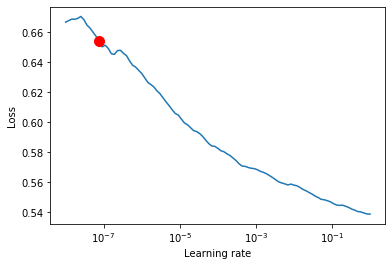

In [8]:
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

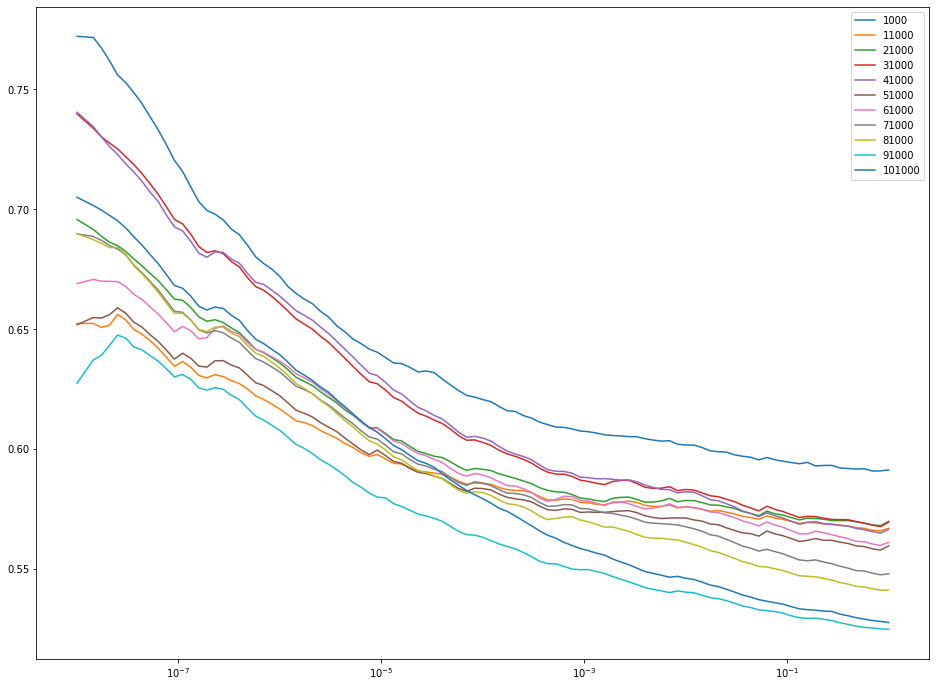

In [21]:
plt.figure(figsize=(16,12))

for result, n_edges in zip(all_results, n_edge_list):

    plt.plot(result["lr"], result["loss"], label=n_edges)

plt.xscale('log') 
plt.legend()

### Test AGNN

In [8]:
test_results = trainer.test(ckpt_path=None)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9951, device='cuda:0'),
 'loss': tensor(0.0445, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'pur': tensor(0.9278, device='cuda:0'),
 'train_loss': tensor(0.0432, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': tensor(0.0480, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0480, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

In [9]:
test_results

[{'train_loss': 0.04323215037584305,
  'val_loss': 0.04799198731780052,
  'eff': 0.9951291084289551,
  'pur': 0.9278425574302673,
  'current_lr': 0.0010000000474974513,
  'loss': 0.04447893798351288,
  'true_positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
  'true': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
  'positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32)},
 {'loss': 0.04802638664841652,
  'true_positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32),
  'true': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32),
  'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32)},
 {'loss': 0.054627347737550735,
  'true_positive': array([0., 1., 1., ..., 1., 1., 0.], dtype=float32),
  'true': array([0., 1., 1., ..., 1., 1., 0.], dtype=float32),
  'positive': array([0., 1., 1., ..., 1., 1., 0.], dtype=float32)},
 {'loss': 0.049103084951639175,
  'true_positive': array([0., 0., 0., ..., 1., 0., 0.], dtype=float32),
  'true': array([0., 0.,

In [10]:
metrics, radius = graph_model_evaluation(model, trainer, "eff", 0.99)
eff, pur, f1 = metrics

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9951, device='cuda:0'),
 'loss': tensor(0.0445, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'pur': tensor(0.9278, device='cuda:0'),
 'train_loss': tensor(0.0432, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': tensor(0.0480, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0480, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.9282901 0.99519676


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9919, device='cuda:0'),
 'loss': tensor(0.0445, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'pur': tensor(0.9469, device='cuda:0'),
 'train_loss': tensor(0.0432, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': tensor(0.0480, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0480, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.94641113 0.9920865


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9897, device='cuda:0'),
 'loss': tensor(0.0445, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'pur': tensor(0.9545, device='cuda:0'),
 'train_loss': tensor(0.0432, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': tensor(0.0480, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0480, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.9544915 0.9898936


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9898, device='cuda:0'),
 'loss': tensor(0.0445, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'pur': tensor(0.9542, device='cuda:0'),
 'train_loss': tensor(0.0432, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': tensor(0.0480, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0480, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.9545326 0.98993236


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9900, device='cuda:0'),
 'loss': tensor(0.0445, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'pur': tensor(0.9537, device='cuda:0'),
 'train_loss': tensor(0.0432, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': tensor(0.0480, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0480, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.9540025 0.99012077


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9899, device='cuda:0'),
 'loss': tensor(0.0445, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'pur': tensor(0.9540, device='cuda:0'),
 'train_loss': tensor(0.0432, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': tensor(0.0480, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0480, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.9543181 0.9900131
Seed solver complete, radius: 0.2620904821591971


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9899, device='cuda:0'),
 'loss': tensor(0.0445, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'pur': tensor(0.9541, device='cuda:0'),
 'train_loss': tensor(0.0432, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': tensor(0.0480, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0480, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'true': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

### Debug

In [9]:
data = model.trainset[0]

In [32]:
e = data.edge_index.numpy()
X = data.x.numpy()

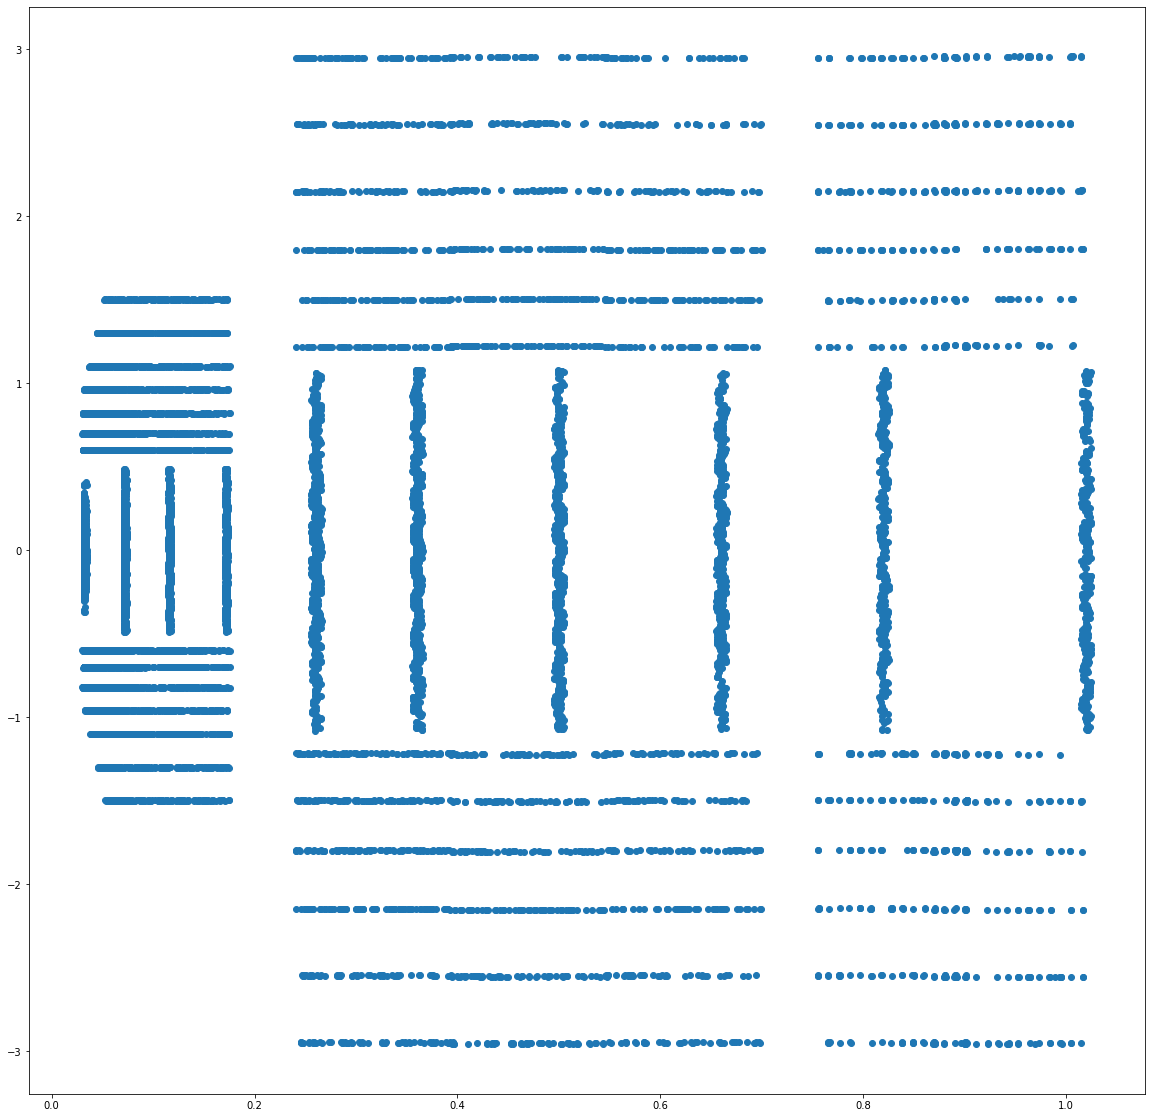

In [20]:
plt.subplots(1, figsize=(20, 20))
plt.scatter(data.x[:,0], data.x[:, 2])

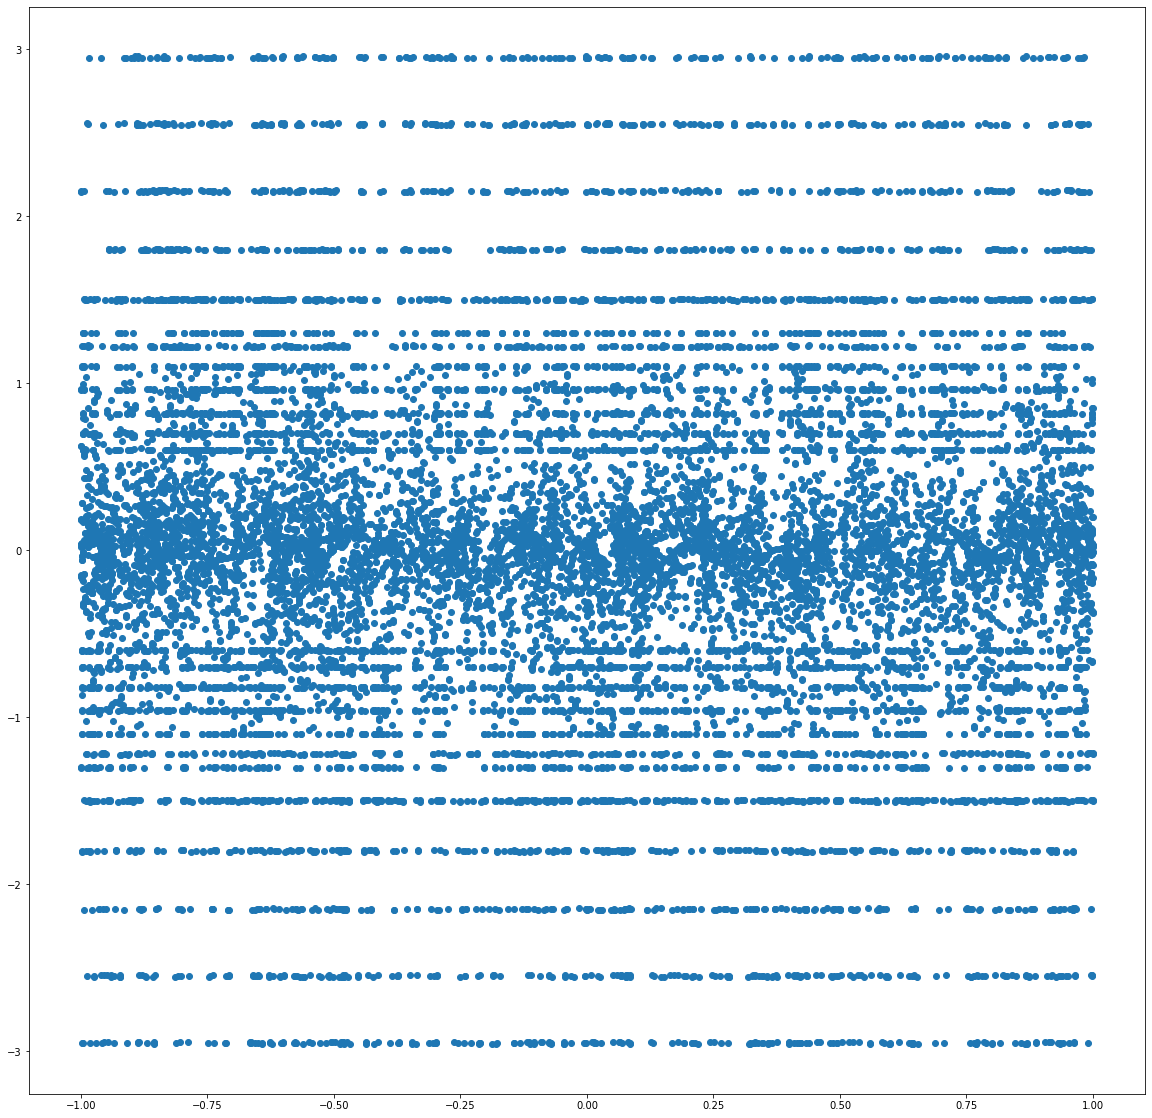

In [21]:
plt.subplots(1, figsize=(20, 20))
plt.scatter(data.x[:,1], data.x[:, 2])

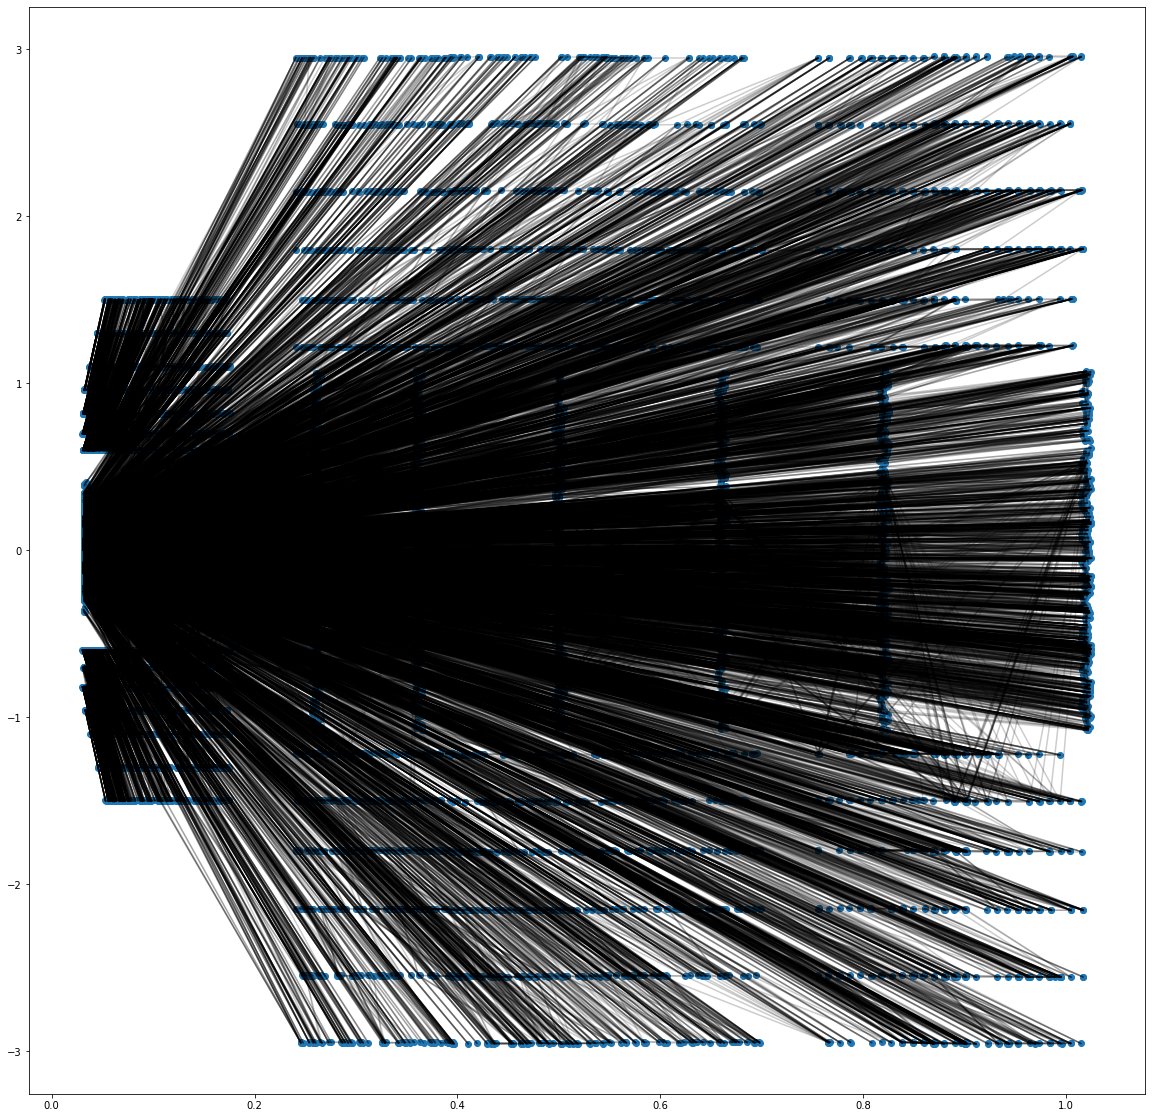

In [41]:
plt.subplots(1, figsize=(20, 20))
num_e = e.shape[1]
plt.scatter(data.x[:,0], data.x[:, 2])
plt.plot([X[e[0, :num_e],0], X[e[1, :num_e], 0]], [X[e[0, :num_e],2], X[e[1, :num_e], 2]], c="k", alpha=0.2);

In [42]:
all_e = np.concatenate(e)

In [50]:
hit_x = np.vstack([data.hid, X.T]).T

In [60]:
hit_x = pd.DataFrame(hit_x[all_e], columns = ["hid", "r", "phi", "z"])

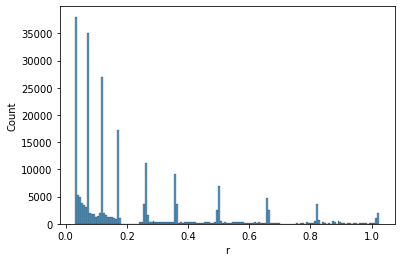

In [76]:
sns.histplot(hit_x.r)

## Checkpointed AGNN Performance

### Train AGNN

In [87]:
from lightning_modules.GNN.utils import graph_model_evaluation

In [93]:
from lightning_modules.GNN.Models.checkpoint_agnn import CheckpointedResAGNN

with open("../lightning_modules/GNN/train_coda_gnn.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)
        
model = CheckpointedResAGNN(hparams)
wandb_logger = WandbLogger(project='End2End-CheckAGNN')
wandb_logger.watch(model)
trainer = Trainer(gpus=1, max_epochs=50, logger=wandb_logger)

wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/wandb/sdk/wandb_run.py", line 1303, in _atexit_cleanup
    self._on_finish()
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/wandb/sdk/wandb_run.py", line 1427, in _on_finish
    self.history._flush()
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/wandb/sdk/wandb_history.py", line 50, in _flush
    self._callback(row=self._data, step=self._step)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/wandb/sdk/wandb_run.py", line 703, in _history_callback
    self._backend.interface.publish_history(row, step)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/wandb/sdk/interface/interface.py", line 172, in publish_history
    self._publish_history(history)
  File "/global/homes/d/danieltm/.con

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [94]:
trainer.fit(model)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name         | Type       | Params
--------------------------------------------
0 | node_encoder | Sequential | 34 K  
1 | edge_network | Sequential | 50 K  
2 | node_network | Sequential | 50 K  
INFO:lightning:
  | Name         | Type       | Params
--------------------------------------------
0 | node_encoder | Sequential | 34 K  
1 | edge_network | Sequential | 50 K  
2 | node_network | Sequential | 50 K  


1

### Test AGNN

In [9]:
test_results = trainer.test(ckpt_path=None)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


../lightning_modules/GNN/gnn_base.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eff = torch.tensor(edge_true_positive/edge_true)
../lightning_modules/GNN/gnn_base.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pur = torch.tensor(edge_true_positive/edge_positive)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9837, device='cuda:0'),
 'loss': tensor(0.1303, device='cuda:0'),
 'preds': array([False, False, False, ..., False, False, False]),
 'pur': tensor(0.5357, device='cuda:0'),
 'train_loss': tensor(0.1393, device='cuda:0'),
 'truth': array([False, False, False, ..., False, False, False]),
 'val_loss': tensor(0.1257, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1268, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(0.1317, device='cuda:0'),
 'positive': ar

In [10]:
metrics, radius = graph_model_evaluation(model, trainer, "eff", 0.99)
eff, pur, f1 = metrics

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9837, device='cuda:0'),
 'loss': tensor(0.1303, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'preds': array([False, False, False, ..., False, False, False]),
 'pur': tensor(0.5357, device='cuda:0'),
 'train_loss': tensor(0.1393, device='cuda:0'),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'truth': array([False, False, False, ..., False, False, False]),
 'val_loss': tensor(0.1257, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1268, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0.,

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.53735983 0.98366463


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9591, device='cuda:0'),
 'loss': tensor(0.1303, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'preds': array([False, False, False, ..., False, False, False]),
 'pur': tensor(0.6224, device='cuda:0'),
 'train_loss': tensor(0.1393, device='cuda:0'),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'truth': array([False, False, False, ..., False, False, False]),
 'val_loss': tensor(0.1257, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1268, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0.,

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.61987036 0.960273


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9885, device='cuda:0'),
 'loss': tensor(0.1303, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'preds': array([False, False, False, ..., False, False, False]),
 'pur': tensor(0.5114, device='cuda:0'),
 'train_loss': tensor(0.1393, device='cuda:0'),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'truth': array([False, False, False, ..., False, False, False]),
 'val_loss': tensor(0.1257, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1268, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0.,

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.5177588 0.9872863


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9907, device='cuda:0'),
 'loss': tensor(0.1303, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'preds': array([False, False, False, ..., False, False, False]),
 'pur': tensor(0.4990, device='cuda:0'),
 'train_loss': tensor(0.1393, device='cuda:0'),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'truth': array([False, False, False, ..., False, False, False]),
 'val_loss': tensor(0.1257, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1268, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0.,

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.5013826 0.99054354


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9903, device='cuda:0'),
 'loss': tensor(0.1303, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'preds': array([False, False, False, ..., False, False, False]),
 'pur': tensor(0.5011, device='cuda:0'),
 'train_loss': tensor(0.1393, device='cuda:0'),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'truth': array([False, False, False, ..., False, False, False]),
 'val_loss': tensor(0.1257, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1268, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0.,

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.50288266 0.9902713


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9900, device='cuda:0'),
 'loss': tensor(0.1303, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'preds': array([False, False, False, ..., False, False, False]),
 'pur': tensor(0.5033, device='cuda:0'),
 'train_loss': tensor(0.1393, device='cuda:0'),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'truth': array([False, False, False, ..., False, False, False]),
 'val_loss': tensor(0.1257, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1268, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0.,

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.50505596 0.98994035
Seed solver complete, radius: 0.06401990963846929


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9900, device='cuda:0'),
 'loss': tensor(0.1303, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'preds': array([False, False, False, ..., False, False, False]),
 'pur': tensor(0.5029, device='cuda:0'),
 'train_loss': tensor(0.1393, device='cuda:0'),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'truth': array([False, False, False, ..., False, False, False]),
 'val_loss': tensor(0.1257, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1268, device='cuda:0'),
 'positive': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0.,

## Interaction Network Performance

### Train Interaction Network

In [16]:
from lightning_modules.GNN.utils import graph_model_evaluation

In [17]:
from lightning_modules.GNN.Models.interaction_gnn import InteractionGNN

with open("../lightning_modules/GNN/train_coda_gnn.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)
        
model = InteractionGNN(hparams)
wandb_logger = WandbLogger(project='End2End-InteractionGNN')
wandb_logger.watch(model)
trainer = Trainer(gpus=1, max_epochs=30, logger=wandb_logger)

_step,29999
_runtime,3907
_timestamp,1611790781
train_loss,0.03472
epoch,29
val_loss,0.04077
eff,0.98991
pur,0.95847
current_lr,0.001


_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,██▇▇▆▅▄▆▄▄▅▃▂▂▂▂▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_loss,█▇▆▅▄▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eff,▁▂▄▄▅▄▆▇▇▇▇▇▇▇█████████████████
pur,▁▁▁▄▅▄▅▅▅▆▇▇▆▇▇███████████████▇
current_lr,▃██████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█


wandb: wandb version 0.10.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [18]:
trainer.fit(model)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 8 K   
1 | edge_encoder           | Sequential | 16 K  
2 | edge_network           | Sequential | 25 K  
3 | node_network           | Sequential | 25 K  
4 | output_edge_classifier | Sequential | 21 K  
INFO:lightning:
  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 8 K   
1 | edge_encoder           | Sequential | 16 K  
2 | edge_network           | Sequential | 25 K  
3 | node_network           | Sequential | 25 K  
4 | output_edge_classifier | Sequential | 21 K  


1

### Test Interaction Network

In [36]:
test_results = trainer.test(ckpt_path=None)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9652, device='cuda:0'),
 'pur': tensor(0.9198, device='cuda:0'),
 'train_loss': tensor(0.0561, device='cuda:0'),
 'val_loss': tensor(0.0469, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0488, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(0.0545, device='cuda:0'),
 'positive': array([0., 0., 1., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 1., ..., 0., 0., 0.], dtype=

In [20]:
metrics, radius = graph_model_evaluation(model, trainer, "eff", 0.99)
eff, pur, f1 = metrics

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9927, device='cuda:0'),
 'loss': tensor(0.0439, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.8176, device='cuda:0'),
 'train_loss': tensor(0.0584, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.0465, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0461, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.81886035 0.99271554


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9869, device='cuda:0'),
 'loss': tensor(0.0439, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.8603, device='cuda:0'),
 'train_loss': tensor(0.0584, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.0465, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0461, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.8595229 0.9871951


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9899, device='cuda:0'),
 'loss': tensor(0.0439, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.8419, device='cuda:0'),
 'train_loss': tensor(0.0584, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.0465, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0461, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.843642 0.9897624


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9902, device='cuda:0'),
 'loss': tensor(0.0439, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.8400, device='cuda:0'),
 'train_loss': tensor(0.0584, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.0465, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0461, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.8411385 0.9902065


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9900, device='cuda:0'),
 'loss': tensor(0.0439, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.8408, device='cuda:0'),
 'train_loss': tensor(0.0584, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.0465, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0461, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.84189314 0.99006397
Seed solver complete, radius: 0.14765616281892896


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.9900, device='cuda:0'),
 'loss': tensor(0.0439, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'pur': tensor(0.8413, device='cuda:0'),
 'train_loss': tensor(0.0584, device='cuda:0'),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'val_loss': tensor(0.0465, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0461, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TES

## Overall Stats and Conclusion

TODO:
* Implement GravNet lightning module with data loading
* Enforce pT cut > 1GeV
* Ensure this is CodaLab
* Just use preprocessed data!

# Hypothesis F

This supposes that the use of GRAPH truth vs PID truth is irrelevant. 

### Train AGNN

In [11]:
from lightning_modules.GNN.utils import graph_model_evaluation

In [14]:
from lightning_modules.GNN.Models.agnn import ResAGNN

with open("../lightning_modules/GNN/train_coda_gnn.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)
        
model = ResAGNN(hparams)
wandb_logger = WandbLogger(project='End2End-AGNN')
wandb_logger.watch(model)
trainer = Trainer(gpus=1, max_epochs=50, logger=wandb_logger)

wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/wandb/sdk/wandb_run.py", line 1303, in _atexit_cleanup
    self._on_finish()
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/wandb/sdk/wandb_run.py", line 1447, in _on_finish
    self._backend.interface.publish_exit(self._exit_code)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/wandb/sdk/interface/interface.py", line 584, in publish_exit
    self._publish(rec)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/wandb/sdk/interface/interface.py", line 432, in _publish
    raise Exception("The wandb backend process has shutdown")
Exception: The wandb backend process has shutdown
wandb: wandb version 0.10.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [16]:
trainer.max_epochs = 70

In [17]:
trainer.fit(model)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 384   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 21 K  
INFO:lightning:
  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 384   
1 | edge_network  | EdgeNetwork | 18 K  
2 | node_network  | NodeNetwork | 21 K  


/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

### Test AGNN

In [12]:
test_results = trainer.test(ckpt_path=None)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
../lightning_modules/GNN/gnn_base.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eff = torch.tensor(edge_true_positive/edge_true)
../lightning_modules/GNN/gnn_base.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pur = torch.tensor(edge_true_positive/edge_positive)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.8308, device='cuda:0'),
 'pur': tensor(0.7664, device='cuda:0'),
 'train_loss': tensor(0.1719, device='cuda:0'),
 'val_loss': tensor(0.1600, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1581, device='cuda:0'),
 'preds': array([False,  True,  True, ..., False, False, False]),
 'truth': array([False, False, False, ..., False, False, False])}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(0.1729, device='cuda:0'),
 'preds': array([ True, False, False, ..., False, False, False]),
 'truth': array([ True, False, False, ..., False, False, False])}
--------------------------------------------------------------------------------
DATALOADER:3 TEST RESULTS
{'loss': tensor(0

In [32]:
metrics, radius = edge_model_evaluation(model, trainer, "eff", 0.99)
eff, pur, f1 = metrics

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5599, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.7179, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([1., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(0.5641, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0.

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.674531 0.9894641


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5599, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.7179, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([1., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(0.5641, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0.

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.76602566 0.9773809


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5599, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.7179, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([1., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(0.5641, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0.

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.66793674 0.98989475
Seed solver complete, radius: 0.09468657616264033


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5599, device='cuda:0'),
 'positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.7179, device='cuda:0'),
 'positive': array([1., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([1., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(0.5641, device='cuda:0'),
 'positive': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true': array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
 'true_positive': array([0.

# Embedding Benchmark

TODO:
* Quickly implement embedding module
* Train
* Run test inference and see best f1

# GravNet Module

TODO:
* Write up GravNet module that should be an embedding killer
* Understand if co-training metric and edge classification is relevant

In [17]:
from lightning_modules.GravNet.Models.vanilla_gravnet import VanillaGravNet

with open("../lightning_modules/GravNet/train_coda_small_gravnet.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)
        
model = VanillaGravNet(hparams)
wandb_logger = WandbLogger(project='GravNetLite')
wandb_logger.watch(model)
trainer = Trainer(gpus=1, max_epochs=10, logger=wandb_logger)

### KNN Debug

Todo:

- [ ] Copy in KNN maker code
- [ ] Apply model to random data on GPU
- [ ] Try different sizes of KNN

In [12]:
import faiss
import faiss.contrib.torch_utils

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
def build_knn(spatial, k):
    
    if device == "cuda":
        res = faiss.StandardGpuResources()
        _, I = faiss.knn_gpu(res, spatial, spatial, k)
    elif device == "cpu":
        index = faiss.IndexFlatL2(spatial.shape[1])
        index.add(spatial)
        _, I = index.search(spatial, k)
        
    I = I[:, 1:]
    
    ind = torch.Tensor.repeat_interleave(torch.arange(I.shape[0], device=device), I.shape[1])
    I = torch.flatten(I)
    
    edge_list = torch.stack([ind, I])
    
    return edge_list

In [83]:
torch.cuda.reset_max_memory_allocated()

In [84]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  240155 KB |  240155 KB |     854 GB |     854 GB |
|       from large pool |  231378 KB |  231378 KB |     772 GB |     772 GB |
|       from small pool |    8776 KB |    8776 KB |      81 GB |      81 GB |
|---------------------------------------------------------------------------|
| Active memory         |  240155 KB |  240155 KB |     854 GB |     854 GB |
|       from large pool |  231378 KB |  231378 KB |     772 GB |

In [85]:
model = VanillaGravNet(hparams).to(device)
model.train()

VanillaGravNet(
  (space_encoder): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
  (feature_encoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
  )
  (space_network): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
  )
  (feature_network): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, e

In [86]:
model.setup("fit")

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021000
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021001
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021002
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021004
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021006
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021007
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021008
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

In [87]:
batch = model.trainset[0].to(device)

In [89]:
spatial = model(batch.x)

torch.Size([12083, 32])


In [91]:
spatial

tensor([[-0.0448, -0.0567, -0.3559,  ...,  0.5205,  0.0851, -0.7749],
        [-0.2232, -0.1707,  0.0106,  ...,  0.3912,  0.3089, -0.3286],
        [-0.1268, -0.3000,  0.2403,  ...,  0.2021,  0.0976, -0.1908],
        ...,
        [ 0.0066,  0.0333, -0.6734,  ...,  0.3288,  0.1993, -0.7898],
        [ 0.0097,  0.0018, -0.6540,  ...,  0.3344,  0.1209, -0.7924],
        [ 0.0078, -0.0013, -0.6530,  ...,  0.3381,  0.1176, -0.7967]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [98]:
%%time
for i in range(100):
    e_spatial = build_knn(spatial, 500)

CPU times: user 2.04 s, sys: 14.6 s, total: 16.6 s
Wall time: 16.6 s


In [109]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  469763 KB |     960 MB |     918 GB |     917 GB |
|       from large pool |  458289 KB |     944 MB |     835 GB |     834 GB |
|       from small pool |   11474 KB |      23 MB |      82 GB |      82 GB |
|---------------------------------------------------------------------------|
| Active memory         |  469763 KB |     960 MB |     918 GB |     917 GB |
|       from large pool |  458289 KB |     944 MB |     835 GB |

In [102]:
res = faiss.StandardGpuResources()
_, I = faiss.knn_gpu(res, spatial, spatial, 500)

### LR Analysis

In [ ]:
lr_finder = trainer.tuner.lr_find(model)

In [ ]:
# Results can be found in
lr_finder.results

In [ ]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
new_lr = lr_finder.suggestion()

# update hparams of the model
model.hparams.lr = new_lr

### Training

In [20]:
%%time
trainer.fit(model)

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021000
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021001
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021002
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021004
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021006
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021007
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021008
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021080
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021081
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021082
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021083
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021084
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021085
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021086
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021087
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021088
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

../lightning_modules/GravNet/gravnet_base.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eff = torch.tensor(cluster_true_positive / cluster_true)
../lightning_modules/GravNet/gravnet_base.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pur = torch.tensor(cluster_true_positive / cluster_positive)
INFO:root:Efficiency: 0.7765873074531555
INFO:root:Purity: 0.009365991689264774
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.8097345232963562
INFO:root:Purity: 0.009663025848567486
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']


INFO:root:Efficiency: 0.3077859580516815
INFO:root:Purity: 0.045024264603853226
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.30306223034858704
INFO:root:Purity: 0.048783522099256516
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.2847772240638733
INFO:root:Purity: 0.043202344328165054
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.3147900402545929
INFO:root:Purity: 0.04907643049955368
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.31698474287986755
INFO:root:Purity: 0.05134967342019081
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021048']
INFO:root:Efficiency: 0.31252139806747437
INFO:root:Purity: 0.053986478596925735
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trac

INFO:root:Efficiency: 0.5538442730903625
INFO:root:Purity: 0.12499313056468964
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.5634218454360962
INFO:root:Purity: 0.13803426921367645
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.5560643672943115
INFO:root:Purity: 0.12134061008691788
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.5643219947814941
INFO:root:Purity: 0.12879793345928192
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.5881386995315552
INFO:root:Purity: 0.14343148469924927
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021048']
INFO:root:Efficiency: 0.5715141892433167
INFO:root:Purity: 0.15820668637752533
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Efficiency: 0.7592987418174744
INFO:root:Purity: 0.18994030356407166
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.7600786685943604
INFO:root:Purity: 0.21283458173274994
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.7525990009307861
INFO:root:Purity: 0.1865594983100891
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.7643755078315735
INFO:root:Purity: 0.19028596580028534
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.7653053998947144
INFO:root:Purity: 0.2213122844696045
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021048']
INFO:root:Efficiency: 0.7498286962509155
INFO:root:Purity: 0.24953684210777283
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codal

INFO:root:Efficiency: 0.8002069592475891
INFO:root:Purity: 0.22498930990695953
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.8056609034538269
INFO:root:Purity: 0.25618061423301697
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.7952351570129395
INFO:root:Purity: 0.21937520802021027
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.8009494543075562
INFO:root:Purity: 0.22087213397026062
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.8052534461021423
INFO:root:Purity: 0.2613154649734497
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021048']
INFO:root:Efficiency: 0.7923946380615234
INFO:root:Purity: 0.28381237387657166
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-coda

INFO:root:Efficiency: 0.8509161472320557
INFO:root:Purity: 0.2764635980129242
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.859390377998352
INFO:root:Purity: 0.31020408868789673
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.8538985252380371
INFO:root:Purity: 0.2674691379070282
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.85965496301651
INFO:root:Purity: 0.2706224024295807
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.8643546104431152
INFO:root:Purity: 0.31256338953971863
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021048']
INFO:root:Efficiency: 0.865878701210022
INFO:root:Purity: 0.3368877172470093
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/tra

INFO:root:Efficiency: 0.8672916293144226
INFO:root:Purity: 0.2927987277507782
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.8722432851791382
INFO:root:Purity: 0.3259580135345459
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.8629331588745117
INFO:root:Purity: 0.2831932008266449
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.8791789412498474
INFO:root:Purity: 0.27913641929626465
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.8729051351547241
INFO:root:Purity: 0.3302878141403198
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021048']
INFO:root:Efficiency: 0.8875470757484436
INFO:root:Purity: 0.3490988612174988
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/


CPU times: user 1min 20s, sys: 3min 26s, total: 4min 47s
Wall time: 4min 36s


1

In [12]:
%%time
trainer.fit(model)

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021000
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021001
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021002
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021004
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021006
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021007
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021008
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021080
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021081
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021082
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021083
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021084
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021085
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021086
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021087
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021088
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Efficiency: 0.5020393133163452
INFO:root:Purity: 0.12214701622724533
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.5191038250923157
INFO:root:Purity: 0.1362672597169876
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']


INFO:root:Efficiency: 0.7163206934928894
INFO:root:Purity: 0.20351441204547882
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.7255232334136963
INFO:root:Purity: 0.23307761549949646
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.6879331469535828
INFO:root:Purity: 0.19777268171310425
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.7239903807640076
INFO:root:Purity: 0.20328164100646973
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.7365756630897522
INFO:root:Purity: 0.23517078161239624
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021048']
INFO:root:Efficiency: 0.723878026008606
INFO:root:Purity: 0.24880044162273407
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-coda

CPU times: user 39 s, sys: 52.2 s, total: 1min 31s
Wall time: 1min 28s


1

In [21]:
trainer.test()

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


INFO:root:Efficiency: 0.8731819987297058
INFO:root:Purity: 0.32209381461143494
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.8901861310005188
INFO:root:Purity: 0.3268089294433594
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.8688974380493164
INFO:root:Purity: 0.29649484157562256
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.8728949427604675
INFO:root:Purity: 0.2840178310871124
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.8797271251678467
INFO:root:Purity: 0.30483773350715637
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021119']
INFO:root:Efficiency: 0.8599191904067993
INFO:root:Purity: 0.30124029517173767
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codal

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': tensor(0.0010),
 'eff': tensor(0.8759),
 'pur': tensor(0.3012),
 'train_loss': tensor(0.3238, device='cuda:0'),
 'val_loss': tensor(0.4425, device='cuda:0')}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.4397, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   273,   284, ..., 11628, 11807, 11989]]),
 'truth': array([False,  True, False, ..., False,  True, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss': tensor(0.4391, device='cuda:0'),
 'preds': array([[    0,     0,     1, ..., 10328, 10328, 10328],
       [   12,  1966,     2, ..., 10222, 10223, 

[{'train_loss': 0.3237735629081726,
  'val_loss': 0.44253265857696533,
  'eff': 0.875904381275177,
  'pur': 0.3011761009693146,
  'current_lr': 0.0010000000474974513},
 {'loss': 0.4397120177745819,
  'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
         [    1,   273,   284, ..., 11628, 11807, 11989]]),
  'truth': array([False,  True, False, ..., False,  True, False]),
  'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
         [ 606,  662,  606, ..., 3861, 4898, 6374]])},
 {'loss': 0.43914151191711426,
  'preds': array([[    0,     0,     1, ..., 10328, 10328, 10328],
         [   12,  1966,     2, ..., 10222, 10223, 10235]]),
  'truth': array([False,  True, False, ..., False, False, False]),
  'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
         [4038, 4068, 4771, ..., 8278, 9154, 9520]])},
 {'loss': 0.4373224377632141,
  'preds': array([[    0,     0,     0, ..., 14294, 14294, 14294],
         [ 1221,  1264,  2016, ..., 14235,

In [9]:
test = [100, 20, 20]

In [13]:
b = np.split(np.arange(0, 140), [sum(test[:x+1]) for x in range(0,len(test))])

In [17]:
[i.tolist() for i in b]

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99],
 [100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119],
 [120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139],
 []]

In [15]:
torch.cuda.reset_max_memory_allocated()

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


In [10]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    7288 KB |    1421 MB |    3450 GB |    3450 GB |
|       from large pool |       0 KB |    1395 MB |    3389 GB |    3389 GB |
|       from small pool |    7288 KB |      35 MB |      60 GB |      60 GB |
|---------------------------------------------------------------------------|
| Active memory         |    7288 KB |    1421 MB |    3450 GB |    3450 GB |
|       from large pool |       0 KB |    1395 MB |    3389 GB |

### Testing

In [10]:
model.eval()
model.validation_step(model.valset[0].to(device), 0)

INFO:root:Efficiency: 0.21574237942695618
INFO:root:Purity: 0.04584141820669174
INFO:root:/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040


tensor(0.4003, device='cuda:0', grad_fn=<MeanBackward0>)

In [8]:
model.hparams.r_test

1

In [9]:
trainer.test()

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


INFO:root:Efficiency: 0.21639254689216614
INFO:root:Purity: 0.04851144179701805
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.21783147752285004
INFO:root:Purity: 0.05128106474876404
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.2059682309627533
INFO:root:Purity: 0.04139622673392296
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.21075589954853058
INFO:root:Purity: 0.040681254118680954
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.22617392241954803
INFO:root:Purity: 0.04882826283574104
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021119']
INFO:root:Efficiency: 0.21313577890396118
INFO:root:Purity: 0.04445068538188934
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/track

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.4132, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,    50,   107, ..., 12071, 12080, 12120]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.4083, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,  3592,  3642, ..., 10263, 10279, 10296]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

[{'loss': 0.41321906447410583,
  'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
         [    1,    50,   107, ..., 12071, 12080, 12120]]),
  'truth': array([False, False, False, ..., False, False, False]),
  'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
         [ 606,  662,  606, ..., 3861, 4898, 6374]])},
 {'loss': 0.40834227204322815,
  'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
         [   12,  3592,  3642, ..., 10263, 10279, 10296]]),
  'truth': array([False, False, False, ..., False, False, False]),
  'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
         [4038, 4068, 4771, ..., 8278, 9154, 9520]])},
 {'loss': 0.4102642238140106,
  'preds': array([[    0,     0,     0, ..., 14294, 14294, 14294],
         [  917,  1552,  1650, ..., 14235, 14287, 14289]]),
  'truth': array([False, False, False, ..., False, False, False]),
  'truth_graph': array([[ 3121,  3121,  3310, ..., 11432, 12165, 12165],
         

In [9]:
model_evaluation(model, trainer, "eff", 0.99)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.4793, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,    18,    50, ..., 12004, 12022, 12128]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.4859, device='cuda:0'),
 'preds': array([[    1,     1,     1, ..., 10328, 10328, 10328],
       [    2,     6,     7, ..., 10298, 10302, 10323]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.04521267804865519 0.11813487924851136


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.1883, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,    18,    50, ..., 12120, 12127, 12128]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1955, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,  3692,  3973, ..., 10313, 10317, 10323]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.04197993996844185 0.38455158332437855


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.0470, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,     2,    18, ..., 12127, 12128, 12137]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0493, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,    45,    59, ..., 10313, 10317, 10323]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.014524573877763994 0.8975662535751345


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.0421, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,     2,    18, ..., 12127, 12128, 12137]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0432, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [    8,    12,    45, ..., 10313, 10317, 10323]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.013084032729075865 0.9187481975120528


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.0371, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,     2,    18, ..., 12127, 12128, 12137]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0361, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [    8,    12,    45, ..., 10313, 10317, 10323]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.011511523935759306 0.935446165745061


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.0365, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,     2,    18, ..., 12127, 12128, 12137]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0348, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [    8,    12,    45, ..., 10313, 10317, 10323]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.011303017408885965 0.9362824384863014


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.0365, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,     2,    18, ..., 12127, 12128, 12137]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0348, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [    8,    12,    45, ..., 10313, 10317, 10323]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.011303487390377648 0.9363230394832668


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.0365, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,     2,    18, ..., 12127, 12128, 12137]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0348, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [    8,    12,    45, ..., 10313, 10317, 10323]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.011302843366291478 0.9362687788111508


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.0365, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,     2,    18, ..., 12127, 12128, 12137]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0348, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [    8,    12,    45, ..., 10313, 10317, 10323]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.011303366981174741 0.9363130532368649


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.0365, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,     2,    18, ..., 12127, 12128, 12137]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0348, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [    8,    12,    45, ..., 10313, 10317, 10323]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.011302302650602187 0.9362247359406218


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.0365, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,     2,    18, ..., 12127, 12128, 12137]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0348, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [    8,    12,    45, ..., 10313, 10317, 10323]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.0113021839428851 0.9362145738160079


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.0365, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,     2,    18, ..., 12127, 12128, 12137]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.0348, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [    8,    12,    45, ..., 10313, 10317, 10323]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.011302232045165382 0.9362182146363566


RuntimeError: value cannot be converted to type float without overflow: 3.85856e+43

# GravNetLite Module

TODO:
* Write up GravNet module that should be an embedding killer
* Understand if co-training metric and edge classification is relevant

In [8]:
from lightning_modules.GravNet.Models.gravnet_lite import GravNetLite
from lightning_modules.GravNet.Models.gravnet_lite import CheckpointGravNetLite

with open("../lightning_modules/GravNet/train_coda_small_gravnet.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)
        
# model = GravNetLite(hparams)
model = CheckpointGravNetLite(hparams)

wandb_logger = WandbLogger(project='GravNetLite')
wandb_logger.watch(model)
trainer = Trainer(gpus=1, max_epochs=10, logger=wandb_logger)

wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### Training

In [9]:
%%time
trainer.fit(model)

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021000
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021001
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021002
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021003
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021004
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021006
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021007
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021008
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021080
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021081
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021082
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021083
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021084
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021085
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021086
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021087
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021088
INFO:root:Loaded event: /global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Efficiency: 0.7456930875778198
INFO:root:Purity: 0.008993963710963726
INFO:root:Loss: 0.9671688675880432
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.7558645606040955
INFO:root:Purity: 0.009020279161632061
INFO:root:Loss: 0.9651855230331421
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']


INFO:root:Efficiency: 0.17227734625339508
INFO:root:Purity: 0.035877738147974014
INFO:root:Loss: 0.44004666805267334
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.18991431593894958
INFO:root:Purity: 0.04306966811418533
INFO:root:Loss: 0.43876850605010986
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.188490092754364
INFO:root:Purity: 0.038034588098526
INFO:root:Loss: 0.4411172568798065
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.1819336712360382
INFO:root:Purity: 0.03888142481446266
INFO:root:Loss: 0.45055022835731506
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.19590942561626434
INFO:root:Purity: 0.04326676204800606
INFO:root:Loss: 0.4414866864681244
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trac

INFO:root:Efficiency: 0.3424849212169647
INFO:root:Purity: 0.09341945499181747
INFO:root:Loss: 0.40597254037857056
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.3531394898891449
INFO:root:Purity: 0.10405413806438446
INFO:root:Loss: 0.40657222270965576
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.345730185508728
INFO:root:Purity: 0.09213846176862717
INFO:root:Loss: 0.41328689455986023
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.3290987014770508
INFO:root:Purity: 0.09654956310987473
INFO:root:Loss: 0.4187864065170288
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.3502291440963745
INFO:root:Purity: 0.10859651863574982
INFO:root:Loss: 0.4083796739578247
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackm

INFO:root:Efficiency: 0.5419126749038696
INFO:root:Purity: 0.1673465520143509
INFO:root:Loss: 0.4295094907283783
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.5408765077590942
INFO:root:Purity: 0.1815502792596817
INFO:root:Loss: 0.4318068027496338
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.530259907245636
INFO:root:Purity: 0.15677772462368011
INFO:root:Loss: 0.43335768580436707
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.5265445113182068
INFO:root:Purity: 0.1641719490289688
INFO:root:Loss: 0.43980732560157776
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.5451125502586365
INFO:root:Purity: 0.18364712595939636
INFO:root:Loss: 0.43141940236091614
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-c

INFO:root:Efficiency: 0.7252085208892822
INFO:root:Purity: 0.23447094857692719
INFO:root:Loss: 0.4387764036655426
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.7324062585830688
INFO:root:Purity: 0.2599785625934601
INFO:root:Loss: 0.43726715445518494
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.7303217649459839
INFO:root:Purity: 0.225267693400383
INFO:root:Loss: 0.44521817564964294
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.7361593842506409
INFO:root:Purity: 0.23205327987670898
INFO:root:Loss: 0.4493556618690491
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.7477255463600159
INFO:root:Purity: 0.2635881304740906
INFO:root:Loss: 0.44021984934806824
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-c

INFO:root:Efficiency: 0.7952760457992554
INFO:root:Purity: 0.2773849666118622
INFO:root:Loss: 0.44080567359924316
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.7943531274795532
INFO:root:Purity: 0.3028761148452759
INFO:root:Loss: 0.44029542803764343
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.784220278263092
INFO:root:Purity: 0.25640350580215454
INFO:root:Loss: 0.4437049329280853
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.7947980761528015
INFO:root:Purity: 0.26338881254196167
INFO:root:Loss: 0.4455887973308563
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.8116150498390198
INFO:root:Purity: 0.30534252524375916
INFO:root:Loss: 0.43614673614501953
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-

INFO:root:Efficiency: 0.858038604259491
INFO:root:Purity: 0.29298660159111023
INFO:root:Loss: 0.43507254123687744
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.8649389147758484
INFO:root:Purity: 0.32682254910469055
INFO:root:Loss: 0.4349185526371002
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.8666460514068604
INFO:root:Purity: 0.275250107049942
INFO:root:Loss: 0.4357320964336395
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.8658732175827026
INFO:root:Purity: 0.2880209982395172
INFO:root:Loss: 0.43943488597869873
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.8724262714385986
INFO:root:Purity: 0.32802653312683105
INFO:root:Loss: 0.4334193170070648
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-co

INFO:root:Efficiency: 0.8681439161300659
INFO:root:Purity: 0.3153902292251587
INFO:root:Loss: 0.43181437253952026
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.8730860948562622
INFO:root:Purity: 0.3541191816329956
INFO:root:Loss: 0.4323548972606659
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.8714727759361267
INFO:root:Purity: 0.2987484037876129
INFO:root:Loss: 0.4334277808666229
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.8773067593574524
INFO:root:Purity: 0.3081204295158386
INFO:root:Loss: 0.4377114772796631
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.8764621615409851
INFO:root:Purity: 0.35731616616249084
INFO:root:Loss: 0.4311078190803528
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Efficiency: 0.8698484301567078
INFO:root:Purity: 0.33270466327667236
INFO:root:Loss: 0.4352751076221466
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.8799691200256348
INFO:root:Purity: 0.3685433566570282
INFO:root:Loss: 0.4354456961154938
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.8748143315315247
INFO:root:Purity: 0.31574833393096924
INFO:root:Loss: 0.4361293613910675
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.879981279373169
INFO:root:Purity: 0.3187994956970215
INFO:root:Loss: 0.4350833296775818
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.8769409656524658
INFO:root:Purity: 0.3749634325504303
INFO:root:Loss: 0.43063074350357056
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-cod

INFO:root:Efficiency: 0.8755707144737244
INFO:root:Purity: 0.3345039188861847
INFO:root:Loss: 0.4301336705684662
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.8828487396240234
INFO:root:Purity: 0.36678239703178406
INFO:root:Loss: 0.4308670163154602
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.876980185508728
INFO:root:Purity: 0.31988805532455444
INFO:root:Loss: 0.43366479873657227
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.888405978679657
INFO:root:Purity: 0.3226487934589386
INFO:root:Loss: 0.4334125816822052
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.8862439393997192
INFO:root:Purity: 0.3747866451740265
INFO:root:Loss: 0.428082674741745
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codal

INFO:root:Efficiency: 0.8749010562896729
INFO:root:Purity: 0.34041544795036316
INFO:root:Loss: 0.43334993720054626
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021040']
INFO:root:Efficiency: 0.8761764168739319
INFO:root:Purity: 0.3747146427631378
INFO:root:Loss: 0.4348010718822479
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021005']
INFO:root:Efficiency: 0.8743811845779419
INFO:root:Purity: 0.3195386826992035
INFO:root:Loss: 0.43433135747909546
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021133']
INFO:root:Efficiency: 0.8808504939079285
INFO:root:Purity: 0.3238605558872223
INFO:root:Loss: 0.437208890914917
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021025']
INFO:root:Efficiency: 0.8811136484146118
INFO:root:Purity: 0.3788640797138214
INFO:root:Loss: 0.433553010225296
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-coda


CPU times: user 3min 12s, sys: 21min 33s, total: 24min 45s
Wall time: 25min 4s


1

In [10]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  193630 KB |    2524 MB |   19165 GB |   19165 GB |
|       from large pool |  191369 KB |    2518 MB |   19081 GB |   19080 GB |
|       from small pool |    2261 KB |      16 MB |      84 GB |      84 GB |
|---------------------------------------------------------------------------|
| Active memory         |  193630 KB |    2524 MB |   19165 GB |   19165 GB |
|       from large pool |  191369 KB |    2518 MB |   19081 GB |

In [15]:
torch.cuda.reset_max_memory_allocated()

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


### Testing

In [18]:
trainer.test(ckpt_path=None)

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


INFO:root:Efficiency: 0.9774364829063416
INFO:root:Purity: 0.09650924056768417
INFO:root:Loss: 0.1662280559539795
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.9848138689994812
INFO:root:Purity: 0.10110729932785034
INFO:root:Loss: 0.17225468158721924
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.9786264896392822
INFO:root:Purity: 0.08465004712343216
INFO:root:Loss: 0.1614999771118164
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.9801778197288513
INFO:root:Purity: 0.07861998677253723
INFO:root:Loss: 0.15623630583286285
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.979468822479248
INFO:root:Purity: 0.09146910905838013
INFO:root:Loss: 0.165895476937294
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.1662, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    0,   251,   273, ..., 11792, 11807, 11989]]),
 'truth': array([False, False,  True, ..., False,  True, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1723, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,  1496,  1966, ..., 10209, 10222, 10261]]),
 'truth': array([False, False,  True, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

[{'loss': 0.1662280559539795,
  'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
         [    0,   251,   273, ..., 11792, 11807, 11989]]),
  'truth': array([False, False,  True, ..., False,  True, False]),
  'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
         [ 606,  662,  606, ..., 3861, 4898, 6374]])},
 {'loss': 0.17225468158721924,
  'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
         [   12,  1496,  1966, ..., 10209, 10222, 10261]]),
  'truth': array([False, False,  True, ..., False, False, False]),
  'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
         [4038, 4068, 4771, ..., 8278, 9154, 9520]])},
 {'loss': 0.1614999771118164,
  'preds': array([[    0,     0,     0, ..., 14294, 14294, 14294],
         [ 1221,  1264,  2016, ..., 14263, 14287, 14289]]),
  'truth': array([ True,  True, False, ..., False, False, False]),
  'truth_graph': array([[ 3121,  3121,  3310, ..., 11432, 12165, 12165],
         [

In [11]:
metrics, radius = model_evaluation(model, trainer, "eff", 0.99)
eff, pur, f1 = metrics

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


INFO:root:Efficiency: 0.8250645399093628
INFO:root:Purity: 0.4307255744934082
INFO:root:Loss: 0.48814156651496887
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.8251959681510925
INFO:root:Purity: 0.4351588785648346
INFO:root:Loss: 0.49622097611427307
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.820193886756897
INFO:root:Purity: 0.39846232533454895
INFO:root:Loss: 0.4909903109073639
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.8309866786003113
INFO:root:Purity: 0.38062721490859985
INFO:root:Loss: 0.49475422501564026
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.8317769169807434
INFO:root:Purity: 0.4135875701904297
INFO:root:Loss: 0.4957301914691925
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-c

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.4881, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   530,  1268, ..., 11245, 11628, 11807]]),
 'truth': array([False, False, False, ..., False, False,  True]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.4962, device='cuda:0'),
 'preds': array([[    0,     0,     1, ..., 10327, 10327, 10328],
       [   12,  1966,     2, ..., 10017, 10046, 10048]]),
 'truth': array([False,  True, False, ..., False,  True,  True]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.4009685051097785 0.8274509852476453


INFO:root:Efficiency: 0.9361152648925781
INFO:root:Purity: 0.27052929997444153
INFO:root:Loss: 0.31460902094841003
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.9485630393028259
INFO:root:Purity: 0.27849557995796204
INFO:root:Loss: 0.32403746247291565
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.9401425123214722
INFO:root:Purity: 0.24386143684387207
INFO:root:Loss: 0.30582481622695923
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.9441775679588318
INFO:root:Purity: 0.229056715965271
INFO:root:Loss: 0.30155080556869507
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.9464865326881409
INFO:root:Purity: 0.25483691692352295
INFO:root:Loss: 0.3123857080936432
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackm

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.3146, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   273,   284, ..., 11628, 11807, 11989]]),
 'truth': array([False,  True, False, ..., False,  True, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.3240, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,  1966,  3669, ..., 10048, 10209, 10222]]),
 'truth': array([False,  True, False, ...,  True, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.2516869759913637 0.9439331675320876


INFO:root:Efficiency: 0.9535136818885803
INFO:root:Purity: 0.226418137550354
INFO:root:Loss: 0.26497894525527954
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.9666067957878113
INFO:root:Purity: 0.22994600236415863
INFO:root:Loss: 0.2693565785884857
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.9601144790649414
INFO:root:Purity: 0.20040468871593475
INFO:root:Loss: 0.25264203548431396
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.9632267951965332
INFO:root:Purity: 0.18832381069660187
INFO:root:Loss: 0.2489645630121231
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.9637061953544617
INFO:root:Purity: 0.2116878628730774
INFO:root:Loss: 0.2606785297393799
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-c

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.2650, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   273,   284, ..., 11628, 11807, 11989]]),
 'truth': array([False,  True, False, ..., False,  True, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.2694, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,  1966,  3669, ..., 10209, 10222, 10261]]),
 'truth': array([False,  True, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.2091255565993137 0.9621677986082837


INFO:root:Efficiency: 0.9641837477684021
INFO:root:Purity: 0.1992696076631546
INFO:root:Loss: 0.23485231399536133
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.9760777354240417
INFO:root:Purity: 0.20155443251132965
INFO:root:Loss: 0.23737302422523499
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.9712100028991699
INFO:root:Purity: 0.1751166135072708
INFO:root:Loss: 0.22193434834480286
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.9729998111724854
INFO:root:Purity: 0.16357864439487457
INFO:root:Loss: 0.21702811121940613
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.9727796316146851
INFO:root:Purity: 0.18483608961105347
INFO:root:Loss: 0.22873090207576752
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/track

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.2349, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   217,   251, ..., 11792, 11807, 11989]]),
 'truth': array([False, False, False, ..., False,  True, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.2374, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,   754,  1359, ..., 10223, 10235, 10261]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.18313376313822055 0.97165841521237


INFO:root:Efficiency: 0.9774364829063416
INFO:root:Purity: 0.15580616891384125
INFO:root:Loss: 0.18580777943134308
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.9880796670913696
INFO:root:Purity: 0.158037006855011
INFO:root:Loss: 0.18812984228134155
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.9832983016967773
INFO:root:Purity: 0.13505080342292786
INFO:root:Loss: 0.17271816730499268
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.984650194644928
INFO:root:Purity: 0.12539024651050568
INFO:root:Loss: 0.1677340567111969
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.9841711521148682
INFO:root:Purity: 0.1429409682750702
INFO:root:Loss: 0.17853285372257233
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.1858, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   159,   217, ..., 11792, 11807, 11989]]),
 'truth': array([False, False, False, ..., False,  True, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1881, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,   754,  1359, ..., 10223, 10235, 10261]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.14255099469459184 0.9833707793421208


INFO:root:Efficiency: 0.9826015830039978
INFO:root:Purity: 0.13667085766792297
INFO:root:Loss: 0.1639542430639267
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.9911822080612183
INFO:root:Purity: 0.13793730735778809
INFO:root:Loss: 0.164781391620636
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.9877365231513977
INFO:root:Purity: 0.11769945174455643
INFO:root:Loss: 0.15128423273563385
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.9887913465499878
INFO:root:Purity: 0.1085214912891388
INFO:root:Loss: 0.14568792283535004
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.9878137707710266
INFO:root:Purity: 0.1247386485338211
INFO:root:Loss: 0.1564684808254242
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-c

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.1640, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   159,   217, ..., 11792, 11807, 11989]]),
 'truth': array([False, False, False, ..., False,  True, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1648, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,   754,  1359, ..., 10223, 10235, 10261]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.12446273044942306 0.9875723948383082


INFO:root:Efficiency: 0.9847763776779175
INFO:root:Purity: 0.1265038102865219
INFO:root:Loss: 0.15217600762844086
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.9924069046974182
INFO:root:Purity: 0.12775103747844696
INFO:root:Loss: 0.15278615057468414
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.9894300103187561
INFO:root:Purity: 0.10872048139572144
INFO:root:Loss: 0.13998845219612122
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.9905582070350647
INFO:root:Purity: 0.10005410015583038
INFO:root:Loss: 0.134597510099411
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.9907940626144409
INFO:root:Purity: 0.11562301963567734
INFO:root:Loss: 0.14551933109760284
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackm

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.1522, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   159,   217, ..., 11792, 11807, 11989]]),
 'truth': array([False, False, False, ..., False,  True, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1528, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,   754,  1359, ..., 10223, 10235, 10261]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.11526538239799997 0.9895206418074588


INFO:root:Efficiency: 0.9851162433624268
INFO:root:Purity: 0.12415098398923874
INFO:root:Loss: 0.14945745468139648
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.9925702214241028
INFO:root:Purity: 0.1254967898130417
INFO:root:Loss: 0.15015436708927155
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.9894300103187561
INFO:root:Purity: 0.10660131275653839
INFO:root:Loss: 0.13725022971630096
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.9910551309585571
INFO:root:Purity: 0.09814632683992386
INFO:root:Loss: 0.13212773203849792
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.9911914467811584
INFO:root:Purity: 0.11346044391393661
INFO:root:Loss: 0.14287744462490082
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trac

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.1495, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   159,   217, ..., 11792, 11807, 11989]]),
 'truth': array([False, False, False, ..., False,  True, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1502, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,   754,  1359, ..., 10223, 10235, 10261]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.11315437206177874 0.9898848188257773


INFO:root:Efficiency: 0.9855239987373352
INFO:root:Purity: 0.12345269322395325
INFO:root:Loss: 0.14879076182842255
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.9926518797874451
INFO:root:Purity: 0.12463735789060593
INFO:root:Loss: 0.14922747015953064
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.9896636009216309
INFO:root:Purity: 0.10597703605890274
INFO:root:Loss: 0.13656437397003174
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.9910551309585571
INFO:root:Purity: 0.0975070521235466
INFO:root:Loss: 0.1312565803527832
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.9913239479064941
INFO:root:Purity: 0.11280768364667892
INFO:root:Loss: 0.14209339022636414
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/track

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.1488, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   159,   217, ..., 11792, 11807, 11989]]),
 'truth': array([False, False, False, ..., False,  True, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1492, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,   754,  1359, ..., 10223, 10235, 10261]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


0.1124815859183147 0.9900202564372422
Seed solver complete, radius: 1.7386286413561776


INFO:root:Efficiency: 0.9853880405426025
INFO:root:Purity: 0.12356926500797272
INFO:root:Loss: 0.14882905781269073
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021132']
INFO:root:Efficiency: 0.9925702214241028
INFO:root:Purity: 0.12480109930038452
INFO:root:Loss: 0.14931844174861908
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021129']
INFO:root:Efficiency: 0.9896636009216309
INFO:root:Purity: 0.1060699000954628
INFO:root:Loss: 0.13666938245296478
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021056']
INFO:root:Efficiency: 0.9912760257720947
INFO:root:Purity: 0.09762370586395264
INFO:root:Loss: 0.13143736124038696
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021118']
INFO:root:Efficiency: 0.9913901686668396
INFO:root:Purity: 0.11282627284526825
INFO:root:Loss: 0.14211198687553406
INFO:root:['/global/cscratch1/sd/danieltm/ExaTrkX/trac

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.1488, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 12138, 12138, 12138],
       [    1,   159,   217, ..., 11792, 11807, 11989]]),
 'truth': array([False, False, False, ..., False,  True, False]),
 'truth_graph': array([[  60,   60,  133, ..., 4898, 6374, 7943],
       [ 606,  662,  606, ..., 3861, 4898, 6374]])}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss': tensor(0.1493, device='cuda:0'),
 'preds': array([[    0,     0,     0, ..., 10328, 10328, 10328],
       [   12,   754,  1359, ..., 10223, 10235, 10261]]),
 'truth': array([False, False, False, ..., False, False, False]),
 'truth_graph': array([[2662, 2662, 4038, ..., 9154, 9520, 9805],
       [4038, 4068, 4771, ..., 8278, 9154, 9520]])}
--------------------------------------------------------------------------------
DATAL

0.11257608413646802 0.99002260237688


In [ ]:
wandb_logger.log_metrics({"99_purity": pur})

In [10]:
pur

0.11557295063784898